# This file explores the ICRISAT district-level data and investigates results from it. No consideration is given to the hybrid methodology in this file. It is intended to be a standalone file that can be run independently of the rest of the project.

In [2]:
%matplotlib inline

In [3]:
import pandas as pd
import numpy as np
import rasterio
import geopandas as gpd
import matplotlib.pyplot as plt
# from matplotlib import rc

# rc('font', **{'family': 'serif', 'serif': ['Computer Modern']})
# rc('text', usetex=True)

In [4]:
icrisat_path = '/Users/michaelfoley/Library/CloudStorage/GoogleDrive-mfoley@g.harvard.edu/My Drive/Subnational_Yield_Database/data/other_databases/ICRISAT/'
shape_path = icrisat_path + '1966_districts_india/1966_districts_india.shp'
data_path = icrisat_path + 'ICRISAT-District Level Data_Apportioned.csv'

In [5]:
# Read the shapefile of district boundaries
districts = gpd.read_file(shape_path)

# Read the CSV containing crop data (which includes columns like 'district_name', 'year', 'crop', 'area', 'production', 'yield')
crop_data = pd.read_csv(data_path)

In [6]:
import os
os.getcwd()

'/Users/michaelfoley/Documents/Old_Documents/Climate/Crops/india_hybrid_methodology/mike'

# First we must match the names from the 1966 boundaries to the data

In [7]:
#Check names from both datasets
# For the first dataframe (CSV data)
selected_year = 2016
unique_csv_districts = pd.DataFrame(crop_data['Dist Name'].unique(), columns=['District'])
unique_csv_districts.to_csv('unique_csv_districts.csv', index=False)

# For the second dataframe (shapefile data)
unique_shape_districts = pd.DataFrame(districts['Dist_Name'].unique(), columns=['District'])
unique_shape_districts.to_csv('unique_shape_districts.csv', index=False)

# Print counts to verify
print(f"Number of unique districts in CSV: {len(unique_csv_districts)}")
print(f"Number of unique districts in shapefile: {len(unique_shape_districts)}")

Number of unique districts in CSV: 311
Number of unique districts in shapefile: 311


In [8]:
district_mapping = {
    # Basic spelling variations
    '24 Parganas': '24 Paraganas',
    'Ahmedabad': 'Ahmadabad',
    'Almorah': 'Almora',
    'Ananthapur': 'Anantapur',
    'Amarawati': 'Amravati',
    'Balasore': 'Baleshwar',
    'Banaskantha': 'Banas Kantha',
    'Barabanki': 'Bara Banki',
    'Beed': 'Bid',
    'Bhatinda': 'Bathinda',
    'Bilashpur': 'Bilaspur2',
    'Bilaspur': 'Bilaspur1',
    'Buldhana': 'Buldana',
    'Burdwan': 'Barddhaman',
    'Buland Shahar': 'Bulandshahr',
    'Chickmagalur': 'Chikmagalur',
    'Chittorgarh': 'Chittaurgarh',
    'Cooch Behar': 'Kochbihar',
    'Darjeeling': 'Darjiling',
    'Dehradun': 'Dehra Dun',
    'Eranakulam': 'Ernakulam',
    'Ferozpur': 'Firozpur',
    'Garhwal': 'Pauri Garhwal',
    'Hazaribagh': 'Hazaribag',
    'Hissar': 'Hisar',
    'Hooghly': 'Hugli',
    'Howrah': 'Haora',
    'Jalore': 'Jalor',
    'Jhunjhunu': 'Jhunjhunun',
    'Kanyakumari': 'Kanniyakumari',
    'Kheri': 'Lakhimpur Kheri',
    #'Koch Bihar': 'Kochbihar',
    'Kutch': 'Kachchh',
    'Lahul & Spiti': 'Lahul and Spiti',
    'Malda': 'Maldah',
    'Mayurbhanja': 'Mayurbhanj',
    'Mehsana': 'Mahesana',
    'Medinipur': 'Midnapore',
    'Midnapur': 'Midnapore',
    'Mirzpur': 'Mirzapur',
    'Mungair': 'Munger',
    'Nainital': 'Naini Tal',
    'Nasik': 'Nashik',
    'Palamau': 'Palamu',
    'Panchmahal': 'Panch Mahals',
    'Pithorgarh': 'Pithoragarh',
    'Purnea': 'Purnia',
    'Purulia': 'Puruliya',
    'Raigad': 'Raigarh2',
    'Raigarh': 'Raigarh1',
    'Ramananthapuram': 'Ramanathapuram',
    'Rae-Bareily': 'Rae Bareli',
    'Sabarkantha': 'Sabar Kantha',
    'Shimoge': 'Shimoga',
    'Swami Madhopur': 'Sawai Madhopur',
    'Dangs': 'The Dangs',
    #'Thirunelveli': 'Tirunelveli',
    'Tiruchirappalli': 'Tiruchchirappalli',
    'Thirunelveli': 'Tirunelveli Kattabo',
    #'Twenty Four Parganas': '24 Paraganas',
    'Uttar Kashi': 'Uttarkashi',
    'Yeotmal': 'Yavatmal',
    'Budaun': 'Badaun',
    
    # Districts with alternative names
    'Bijapur / Vijayapura': 'Bijapur',
    'Chengalpattu MGR / Kanchipuram': 'Chengalpattu',
    'Dakshina Kannada': 'Dakshin Kannad',
    'Uttara Kannada': 'Uttar Kannand',
    #'North Kanara': 'Uttar Kannand',
    #'South Kanara': 'Dakshin Kannad',
    'Gulbarga / Kalaburagi': 'Gulbarga',
    'Khandwa / East Nimar': 'East Nimar',
    'Khargone / West Nimar': 'Khargone',
    'Kodagu / Coorg': 'Kodagu',
    'Mahabubnagar': 'Mahbubnagar',
    'Mahendragarh / Narnaul': 'Mahendragarh',
    'North Cachar Hil / Dima hasao': 'North Cachar Hills',
    'Phulbani ( Kandhamal )': 'Phulbani',
    'Roopnagar / Ropar': 'Rupnagar',
    'S.P.S. Nellore': 'Nellore',
    'Santhal Paragana / Dumka': 'Santhal Paragana',
    'Seoni / Shivani': 'Seoni',
    'Shahabad (now part of Bhojpur district)': 'Shahabad',
    'Vadodara / Baroda': 'Vadodara',
    #'West Nimar': 'Khargone',
    #'Dumka': 'Santhal Paragana',
    'North Arcot / Vellore': 'North Arcot',
    'South Arcot / Cuddalore': 'South Arcot',
    #'Cuddalore': 'South Arcot',
    #'Vellore': 'North Arcot',
    'Kadapa YSR': 'Cuddapah',
    'Visakhapatnam': 'Vishakhapatnam',
    'The Nilgiris': 'Nilgiris',
    'Tiruchirapalli / Trichy': 'Tiruchchirappalli'
}

# # First filter out the NA district
# districts_no_na = districts[districts['Dist_Name'] != 'NA'].copy()

# # Apply the mapping to the crop data to match shapefile names
# crop_data['Dist Name'] = crop_data['Dist Name'].map(district_mapping).fillna(crop_data['Dist Name'])

In [9]:
# Reverse the district_mapping dictionary
reverse_mapping = {v: k for k, v in district_mapping.items()}

# First filter out the NA district
districts_no_na = districts[districts['Dist_Name'] != 'NA'].copy()

# Replace Uttaranchal with Uttarakhand
districts_no_na = districts_no_na.replace('Uttaranchal', 'Uttarakhand')

# Move to Saharanpur to Uttar Pradesh
districts_no_na.loc[districts_no_na['Dist_Name'] == 'Saharanpur', 'NAME_1'] = 'Uttar Pradesh'

In [10]:
# Apply the reverse mapping to the districts dataframe
districts_no_na['Dist_Name'] = districts_no_na['Dist_Name'].map(reverse_mapping).fillna(districts_no_na['Dist_Name'])
districts_no_na.to_file('/Users/michaelfoley/Library/CloudStorage/GoogleDrive-mfoley@g.harvard.edu/My Drive/Subnational_Yield_Database/data/processed/IND/icrisat_apportioned/icrisat_boundary_match.shp')

In [11]:
# Then merge
merged = districts_no_na.merge(crop_data, left_on="Dist_Name", right_on="Dist Name", how="left", indicator=True)

In [12]:
# Print districts that appear in shapefile but not in crop data
print("Districts in shapefile but not in crop data:")
left_only = merged[merged['_merge'] == 'left_only']['Dist_Name'].tolist()
print(left_only)

# Print districts that appear in crop data but don't match shapefile
print("\nDistricts in crop data that don't match shapefile:")
right_only = merged[merged['_merge'] == 'right_only']['Dist Name'].tolist()
print(right_only)

# Print count of districts in each dataset for comparison
print(f"\nNumber of districts in shapefile (excluding NA): {len(districts_no_na)}")
print(f"Number of successfully matched districts: {len(merged[merged['_merge'] == 'both'])}")

Districts in shapefile but not in crop data:
[]

Districts in crop data that don't match shapefile:
[]

Number of districts in shapefile (excluding NA): 310
Number of successfully matched districts: 16098


In [13]:
# Check for missing or zero wheat production values
year_crop_data = crop_data[crop_data['Year'] == selected_year].copy()

print("Districts with zero wheat production:")
print(year_crop_data[year_crop_data['WHEAT PRODUCTION (1000 tons)'] == 0]['Dist Name'].tolist())

print("\nDistricts with NaN wheat production:")
print(year_crop_data[year_crop_data['WHEAT PRODUCTION (1000 tons)'].isna()]['Dist Name'].tolist())

# Also check the value distribution
print("\nWheat production value summary:")
print(year_crop_data['WHEAT PRODUCTION (1000 tons)'].describe())

# Check if any districts in the merged data have missing wheat production
merged_year = merged[merged['Year'] == selected_year].copy()
print("\nNumber of districts in merged data with missing wheat production:")
print(merged_year['WHEAT PRODUCTION (1000 tons)'].isna().sum())

Districts with zero wheat production:
['Srikakulam', 'Visakhapatnam', 'East Godavari', 'West Godavari', 'Krishna', 'Guntur', 'S.P.S. Nellore', 'Ananthapur', 'Kadapa YSR', 'Chittoor', 'Warangal', 'Khammam', 'Karimnagar', 'Bangalore', 'Kolar', 'Tumkur', 'Mysore', 'Mandya', 'Hassan', 'Shimoge', 'Chickmagalur', 'Dakshina Kannada', 'Uttara Kannada', 'Kodagu / Coorg', 'Chengalpattu MGR / Kanchipuram', 'South Arcot / Cuddalore', 'North Arcot / Vellore', 'Salem', 'Coimbatore', 'Tiruchirapalli / Trichy', 'Thanjavur', 'Madurai', 'Ramananthapuram', 'Thirunelveli', 'The Nilgiris', 'Kanyakumari', 'Bombay', 'Raigad', 'Ratnagiri', 'North Cachar Hil / Dima hasao', 'Alappuzha', 'Kannur', 'Eranakulam', 'Kottayam', 'Kozhikode', 'Malappuram', 'Palakkad', 'Kollam', 'Thrissur', 'Thiruvananthapuram']

Districts with NaN wheat production:
[]

Wheat production value summary:
count     311.000000
mean      363.224502
std       545.721823
min         0.000000
25%         0.535000
50%       104.050000
75%       5

In [14]:
# Crops available in the dataset
available_crops = [name for name in merged.columns if 'YIELD' in name]

<Axes: >

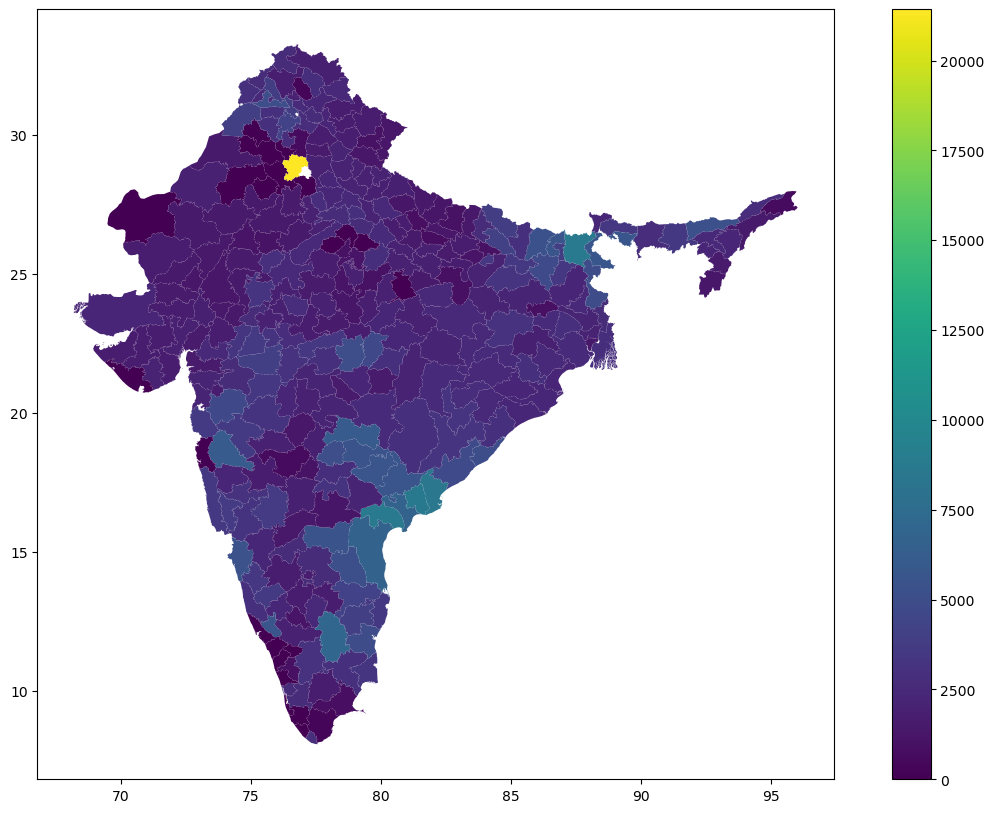

In [15]:
#Test it out
filtered = merged[merged["Year"] == 2016]
filtered.plot(column='MAIZE YIELD (Kg per ha)', legend=True, figsize=(15, 10))

In [16]:
#Typo in yield for Rohtak in 2016 - maize production way too high at 15 instead of likely 1.5?
test_rohtak = merged[merged['Dist_Name'] == 'Rohtak']
print(test_rohtak[['Dist_Name', 'Year', 'MAIZE AREA (1000 ha)', 'MAIZE PRODUCTION (1000 tons)', 'MAIZE YIELD (Kg per ha)']])

     Dist_Name  Year  MAIZE AREA (1000 ha)  MAIZE PRODUCTION (1000 tons)  \
3224    Rohtak  1966                  4.00                           4.0   
3225    Rohtak  1967                  6.00                           6.0   
3226    Rohtak  1968                  6.00                           4.0   
3227    Rohtak  1969                  7.00                           5.0   
3228    Rohtak  1970                  6.40                           6.0   
3229    Rohtak  1971                  8.00                           6.0   
3230    Rohtak  1972                  7.70                           6.0   
3231    Rohtak  1973                  6.70                           6.0   
3232    Rohtak  1974                  7.30                           5.0   
3233    Rohtak  1975                  7.10                           7.0   
3234    Rohtak  1976                  6.40                           5.0   
3235    Rohtak  1977                  4.20                           1.0   
3236    Roht

# Plot of wheat yields over time

In [17]:
wheat_data = merged[['Year', 'State Name', 'Dist Name', 'WHEAT AREA (1000 ha)', 'WHEAT PRODUCTION (1000 tons)', 'WHEAT YIELD (Kg per ha)']]

In [18]:
nonzero_yield = wheat_data[wheat_data['WHEAT YIELD (Kg per ha)'] > 0]

years = np.unique(nonzero_yield['Year'])
wheat_yields = np.zeros(len(years))
wheat_productions = np.zeros(len(years))
wheat_areas = np.zeros(len(years))

In [19]:
for ind, year in enumerate(years):
    wheat_year = nonzero_yield[nonzero_yield['Year'] == year]
    wheat_yields[ind] = np.average(wheat_year['WHEAT YIELD (Kg per ha)'], weights=wheat_year['WHEAT AREA (1000 ha)'])/(1000)
    wheat_productions[ind] = np.sum(wheat_year['WHEAT PRODUCTION (1000 tons)'])/1000
    wheat_areas[ind] = np.sum(wheat_year['WHEAT AREA (1000 ha)'])/1000


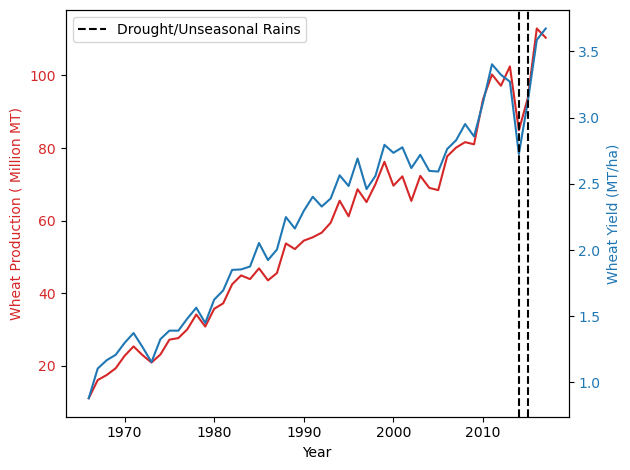

In [20]:
fig, ax1 = plt.subplots()

color = 'tab:red'
ax1.set_xlabel('Year')
ax1.set_ylabel('Wheat Production ( Million MT)', color=color)
ax1.plot(years, wheat_productions, color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis
color = 'tab:blue'
ax2.set_ylabel('Wheat Yield (MT/ha)', color = color)  # we already handled the x-label with ax1
ax2.plot(years, wheat_yields, color = color)
ax2.tick_params(axis='y', labelcolor=color)

plt.axvline(2014, color='k', linestyle='--', label='Drought/Unseasonal Rains')
plt.axvline(2015, color='k', linestyle='--')
plt.legend()

fig.tight_layout()  # otherwise the right y-label is slightly clipped

# Preprocess crop data

In [21]:
def preprocess_crop_data(gdf, crops, min_yield_threshold=0.001):
    """
    Preprocess the geodataframe to filter out zero or near-zero values
    
    Parameters:
    gdf (GeoDataFrame): Original geodataframe with crop data
    crops (list): List of crop names to preprocess
    min_yield_threshold (float): Minimum valid yield value
    
    Returns:
    GeoDataFrame: Processed geodataframe with zeros treated as NaN
    """
    processed_gdf = gdf.copy()
    
    # Process each crop
    for crop in crops:
        yield_col = f"{crop} YIELD (Kg per ha)"
        area_col = f"{crop} AREA (1000 ha)"
        
        # Skip if columns don't exist
        if yield_col not in processed_gdf.columns:
            continue
            
        # Convert zeros and values below threshold to NaN
        mask = (processed_gdf[yield_col] <= min_yield_threshold)
        processed_gdf.loc[mask, yield_col] = np.nan
        
        # If area column exists, also check for zero area
        if area_col in processed_gdf.columns:
            # If area is zero/near-zero, yield should be NaN
            area_mask = (processed_gdf[area_col] <= min_yield_threshold)
            processed_gdf.loc[area_mask, yield_col] = np.nan
    
    return processed_gdf

In [22]:
# Before calculating correlations or trends
crops_to_analyze = ['RICE', 'WHEAT', 'MAIZE', 'KHARIF SORGHUM', 'RABI SORGHUM', 'SOYABEAN', 'GROUNDNUT', 'COTTON', 'SUGARCANE', 'BARLEY']
filtered_gdf = preprocess_crop_data(merged, crops_to_analyze)

# Crop Migration Plot

In [23]:
import pandas as pd
import re

# Assuming df is your DataFrame with the columns shown above
columns = merged.columns

# Define a function to extract crop names from column titles
def extract_crops(columns):
    # Regular expression to match crop names
    # Looks for words before AREA, PRODUCTION, or YIELD
    pattern = r'(.+?)\s+(AREA|PRODUCTION|YIELD)'
    
    crops = set()
    for col in columns:
        match = re.match(pattern, col)
        if match:
            crop_name = match.group(1).strip()
            crops.add(crop_name)
    
    return sorted(list(crops))

# Extract unique crops
unique_crops = extract_crops(columns)

# Print the result
print("Unique crops:")
for i, crop in enumerate(unique_crops, 1):
    print(f"{i}. {crop}")

Unique crops:
1. BARLEY
2. CASTOR
3. CHICKPEA
4. COTTON
5. FINGER MILLET
6. FODDER
7. FRUITS
8. FRUITS AND VEGETABLES
9. GROUNDNUT
10. KHARIF SORGHUM
11. LINSEED
12. MAIZE
13. MINOR PULSES
14. OILSEEDS
15. ONION
16. PEARL MILLET
17. PIGEONPEA
18. POTATOES
19. RABI SORGHUM
20. RAPESEED AND MUSTARD
21. RICE
22. SAFFLOWER
23. SESAMUM
24. SORGHUM
25. SOYABEAN
26. SUGARCANE
27. SUNFLOWER
28. VEGETABLES
29. WHEAT


In [24]:
import pandas as pd
import geopandas as gpd
import numpy as np
from shapely.geometry import Point
import re

# Assuming 'gdf' is your GeoDataFrame with district polygons and crop data
def calculate_weighted_crop_centers(gdf):

    # First, create India boundary by dissolving all district polygons
    india_boundary = gdf.copy()
    india_boundary = india_boundary.dissolve()  # Dissolve all polygons into one

    # Make a copy to avoid modifying the original
    gdf_with_centroids = gdf.copy()
    
    # Get the original CRS to convert back later
    original_crs = gdf.crs
    
    # Project to a suitable projected CRS for India
    # UTM Zone 43N covers most of India (EPSG:32643)
    # You might need to adjust this depending on your specific area of interest
    projected_gdf = gdf_with_centroids.to_crs(epsg=32643)
    
    # Calculate centroids in the projected CRS
    projected_gdf['centroid'] = projected_gdf.geometry.centroid
    
    # Convert centroids back to geographic coordinates
    centroids_geo = gpd.GeoDataFrame(
        geometry=projected_gdf['centroid'],
        crs=projected_gdf.crs
    ).to_crs(original_crs)
    
    # Extract lat/lon coordinates
    gdf_with_centroids['centroid_lon'] = centroids_geo.geometry.x
    gdf_with_centroids['centroid_lat'] = centroids_geo.geometry.y
    
    # Get list of crops and years
    crop_pattern = r'(.+?)\s+PRODUCTION'
    production_cols = [col for col in gdf.columns if 'PRODUCTION' in col]
    crops = [re.match(crop_pattern, col).group(1) for col in production_cols]
    years = gdf['Year'].unique()
    
    # Dictionary to store results
    crop_centers = {}
    
    # Calculate weighted centers for each crop and year
    for crop in crops:
        crop_centers[crop] = []
        production_col = f"{crop} PRODUCTION (1000 tons)"
        
        # Skip if the crop production column doesn't exist
        if production_col not in gdf.columns:
            continue
            
        for year in years:
            # Filter for the current year
            year_data = gdf_with_centroids[gdf_with_centroids['Year'] == year].copy()
            
            # Skip years with no data for this crop
            if year_data[production_col].sum() == 0:
                continue
                
            # Calculate the weighted centroid
            total_production = year_data[production_col].sum()
            
            # Skip if total production is zero (avoid division by zero)
            if total_production == 0:
                continue
                
            # Weight the coordinates by production
            weighted_lat = np.sum(year_data['centroid_lat'] * year_data[production_col]) / total_production
            weighted_lon = np.sum(year_data['centroid_lon'] * year_data[production_col]) / total_production
            
            # Store the weighted center with year
            crop_centers[crop].append({
                'year': year,
                'weighted_lat': weighted_lat,
                'weighted_lon': weighted_lon,
                'total_production': total_production
            })
    
    # Convert results to DataFrames for easier handling
    result_dfs = {}
    for crop, centers in crop_centers.items():
        if centers:  # Only create DataFrame if we have data
            result_dfs[crop] = pd.DataFrame(centers)
            # Create Point geometry for mapping
            result_dfs[crop]['geometry'] = result_dfs[crop].apply(
                lambda row: Point(row['weighted_lon'], row['weighted_lat']), axis=1
            )
            # Convert to GeoDataFrame
            result_dfs[crop] = gpd.GeoDataFrame(result_dfs[crop], geometry='geometry', crs=original_crs)
    
    return result_dfs, india_boundary

# Apply the function to get weighted centers
weighted_centers, india_boundary = calculate_weighted_crop_centers(filtered_gdf)

In [25]:
# Step 4: Visualize or analyze the migration patterns
def analyze_crop_migration(weighted_centers):
    results = {}
    for crop, df in weighted_centers.items():
        if len(df) < 2:  # Need at least two years to analyze migration
            continue
            
        # Sort by year
        df = df.sort_values('year')
        
        # Calculate year-to-year displacement
        df['prev_lat'] = df['weighted_lat'].shift(1)
        df['prev_lon'] = df['weighted_lon'].shift(1)
        
        # Calculate distance in kilometers using Haversine formula
        # (simplified approximation)
        earth_radius = 6371  # km
        df['lat_displacement'] = (df['weighted_lat'] - df['prev_lat']) * 111  # ~111 km per degree
        df['lon_displacement'] = (df['weighted_lon'] - df['prev_lon']) * 111 * np.cos(np.radians(df['weighted_lat']))
        
        # Total displacement and direction
        df['displacement_km'] = np.sqrt(df['lat_displacement']**2 + df['lon_displacement']**2)
        df['direction'] = np.degrees(np.arctan2(df['lat_displacement'], df['lon_displacement']))
        
        # Average annual displacement
        avg_annual_disp = df['displacement_km'].mean()
        total_disp = np.sqrt(
            (df['weighted_lat'].iloc[-1] - df['weighted_lat'].iloc[0])**2 * 111**2 + 
            (df['weighted_lon'].iloc[-1] - df['weighted_lon'].iloc[0])**2 * (111 * np.cos(np.radians(df['weighted_lat'].mean())))**2
        )
        
        # Store results
        results[crop] = {
            'avg_annual_displacement_km': avg_annual_disp,
            'total_displacement_km': total_disp,
            'start_year': df['year'].min(),
            'end_year': df['year'].max(),
            'trajectory': df[['year', 'weighted_lat', 'weighted_lon', 'displacement_km', 'direction']]
        }
    
    return results

# Analyze migration patterns
migration_analysis = analyze_crop_migration(weighted_centers)

In [26]:
import pandas as pd
import geopandas as gpd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import FancyArrowPatch
from shapely.geometry import Point
import re
from scipy.spatial.distance import pdist, squareform

plot_path = '/Users/michaelfoley/Library/CloudStorage/GoogleDrive-mfoley@g.harvard.edu/My Drive/Subnational_Yield_Database/plots/country/IND/'

def calculate_uncertainty_metrics(df):
    """
    Calculate uncertainty metrics based on standard deviation of positions
    for first five years and last five years
    
    Parameters:
    df (GeoDataFrame): DataFrame with weighted centers for a crop, sorted by year
    
    Returns:
    tuple: (start_uncertainty, end_uncertainty) in degrees
    """
    # Get first and last 5 years (or fewer if not enough data)
    first_years = df.head(min(5, len(df)))
    last_years = df.tail(min(5, len(df)))
    
    # Function to calculate average pairwise distance
    def calc_avg_distance(points_df):
        if len(points_df) <= 1:
            return 0
            
        # Extract coordinates
        coords = points_df[['weighted_lon', 'weighted_lat']].values
        
        # Calculate pairwise distances
        distances = pdist(coords)
        
        # Return average distance
        return np.mean(distances)
    
    start_uncertainty = calc_avg_distance(first_years)
    end_uncertainty = calc_avg_distance(last_years)
    
    return start_uncertainty, end_uncertainty


In [27]:
def plot_crop_migration_vector_with_uncertainty(crop, weighted_centers, india_boundary):
    """
    Plot start and end points with vector showing overall migration direction
    Circle/square size indicates uncertainty based on standard deviation
    
    Parameters:
    crop (str): The crop name to plot
    weighted_centers (dict): Dictionary of GeoDataFrames with weighted centers
    india_boundary (GeoDataFrame): Boundary of India for context
    """
    if crop not in weighted_centers:
        print(f"No data available for {crop}")
        return
        
    df = weighted_centers[crop].sort_values('year')
    
    # Skip if we don't have at least start and end points
    if len(df) < 2:
        print(f"Not enough years of data for {crop}")
        return
    
    # Calculate uncertainty metrics
    start_uncertainty, end_uncertainty = calculate_uncertainty_metrics(df)
    
    # Scale factor for marker sizes - adjust as needed for visualization
    # This converts the uncertainty measure to a reasonable marker size
    scale_factor = 500
    min_marker_size = 50
    
    # Get just the first and last points
    start_point = df.iloc[0]
    end_point = df.iloc[-1]
    
    # Create a map
    fig, ax = plt.subplots(figsize=(12, 10))
    
    # Plot India boundary
    india_boundary.boundary.plot(ax=ax, color='black', linewidth=1, alpha=0.5)
    
    # Plot start and end points with sizes reflecting uncertainty
    # Add a minimum size to ensure visibility even with low uncertainty
    start_size = min_marker_size + (start_uncertainty * scale_factor)
    end_size = min_marker_size + (end_uncertainty * scale_factor)
    
    ax.plot(start_point.geometry.x, start_point.geometry.y, 'o', 
            markersize=np.sqrt(start_size), color='green', 
            label=f"Start ({int(start_point.year)})")
    ax.plot(end_point.geometry.x, end_point.geometry.y, 's', 
            markersize=np.sqrt(end_size), color='red', 
            label=f"End ({int(end_point.year)})")
    
    # Calculate vector properties
    dx = end_point.geometry.x - start_point.geometry.x
    dy = end_point.geometry.y - start_point.geometry.y
    
    # Calculate distance and direction
    distance_degrees = np.sqrt(dx**2 + dy**2)
    # Approximate conversion to km (rough estimate, depends on latitude)
    avg_lat = (start_point.geometry.y + end_point.geometry.y) / 2
    distance_km = distance_degrees * 111 * np.cos(np.radians(avg_lat))
    direction = np.degrees(np.arctan2(dy, dx))
    
    # Direction in compass terms
    compass_dirs = ["E", "NE", "N", "NW", "W", "SW", "S", "SE", "E"]
    compass_idx = round(((direction % 360) / 45)) % 8
    compass_dir = compass_dirs[compass_idx]
    
    # Draw the arrow
    arrow = FancyArrowPatch(
        (start_point.geometry.x, start_point.geometry.y),
        (end_point.geometry.x, end_point.geometry.y),
        arrowstyle='-|>', mutation_scale=20, 
        color='blue', linewidth=2
    )
    ax.add_patch(arrow)
    
    # Add annotation about the shift and uncertainty
    years_span = end_point.year - start_point.year
    annual_shift = distance_km / years_span if years_span > 0 else 0
    
    ax.annotate(
        f"Total shift: {distance_km:.1f} km {compass_dir}\n"
        f"Period: {int(start_point.year)}-{int(end_point.year)} ({years_span} years)\n"
        f"Annual shift: {annual_shift:.2f} km/year\n"
        f"Start uncertainty: {start_uncertainty:.4f}°\n"
        f"End uncertainty: {end_uncertainty:.4f}°",
        xy=((start_point.geometry.x + end_point.geometry.x) / 2,
            (start_point.geometry.y + end_point.geometry.y) / 2),
        xytext=(10, 10), textcoords='offset points',
        bbox=dict(boxstyle='round,pad=0.5', fc='yellow', alpha=0.7)
    )
    
    # Set title and labels
    ax.set_title(f"Migration of Production-Weighted Center for {crop} ({int(start_point.year)}-{int(end_point.year)})")
    ax.set_xlabel("Longitude")
    ax.set_ylabel("Latitude")
    ax.legend(loc='upper right')
    
    # Add a note explaining the marker size
    plt.figtext(0.02, 0.02, 
                "Note: Marker size represents spatial variability of the crop's center\n"
                "in the first five and last five years of available data.", 
                ha='left', fontsize=9, bbox=dict(boxstyle='round', alpha=0.1))
    
    plt.tight_layout()
    return fig, ax

In [28]:
def plot_multiple_crop_vectors_with_uncertainty(crops, weighted_centers, india_boundary):
    """
    Plot vectors for multiple crops in a single figure with uncertainty in marker sizes
    
    Parameters:
    crops (list): List of crop names to plot
    weighted_centers (dict): Dictionary of GeoDataFrames with weighted centers
    india_boundary (GeoDataFrame): Boundary of India for context
    """
    # Create a map
    fig, ax = plt.subplots(figsize=(14, 12))
    
    # Plot India boundary
    india_boundary.boundary.plot(ax=ax, color='black', linewidth=1, alpha=0.5)
    
    # Color map for different crops
    colors = plt.cm.tab10.colors
    
    # Scale factor for marker sizes
    scale_factor = 500
    min_marker_size = 30
    
    # Plot vectors for each crop
    legend_elements = []
    
    for i, crop in enumerate(crops):
        if crop not in weighted_centers:
            print(f"No data available for {crop}")
            continue
            
        df = weighted_centers[crop].sort_values('year')
        
        # Skip if we don't have at least start and end points
        if len(df) < 2:
            print(f"Not enough years of data for {crop}")
            continue
        
        # Calculate uncertainty metrics
        start_uncertainty, end_uncertainty = calculate_uncertainty_metrics(df)
        
        # Get just the first and last points
        start_point = df.iloc[0]
        end_point = df.iloc[-1]
        
        # Use color from our color map
        color = colors[i % len(colors)]
        
        # Calculate marker sizes based on uncertainty
        start_size = min_marker_size + (start_uncertainty * scale_factor)
        end_size = min_marker_size + (end_uncertainty * scale_factor)
        
        # Plot start and end points
        ax.plot(start_point.geometry.x, start_point.geometry.y, 'o', 
                markersize=np.sqrt(start_size), color=color, alpha=0.7)
        ax.plot(end_point.geometry.x, end_point.geometry.y, 's', 
                markersize=np.sqrt(end_size), color=color, alpha=0.7)
        
        # Draw the arrow
        arrow = FancyArrowPatch(
            (start_point.geometry.x, start_point.geometry.y),
            (end_point.geometry.x, end_point.geometry.y),
            arrowstyle='-|>', mutation_scale=15, 
            color=color, linewidth=2, alpha=0.8
        )
        ax.add_patch(arrow)
        
        # Add to legend elements
        legend_elements.append((color, crop, f"{int(start_point.year)}-{int(end_point.year)}"))
    
    # Set title and labels
    ax.set_title(f"Migration of Production-Weighted Centers for Major Crops")
    ax.set_xlabel("Longitude")
    ax.set_ylabel("Latitude")
    
    # Create custom legend
    handles = [FancyArrowPatch((0, 0), (1, 0), arrowstyle='-|>', 
                              color=color, linewidth=2) 
              for color, crop, years in legend_elements]
    labels = [f"{crop} ({years})" for color, crop, years in legend_elements]
    
    ax.legend(handles, labels, loc='upper right')
    
    # Add a note explaining the marker size
    plt.figtext(0.575, 0.075, 
                "Note: Marker size represents spatial variability of each crop's center\n"
                "in the first five and last five years of available data.\n"
                "Circles indicate starting positions, squares indicate ending positions.", 
                ha='left', fontsize=9, bbox=dict(boxstyle='round', alpha=0.1))
    
    plt.tight_layout()
    plt.savefig('/Users/michaelfoley/Library/CloudStorage/GoogleDrive-mfoley@g.harvard.edu/My Drive/Subnational_Yield_Database/plots/country/IND/crop_migration_vectors.png')
    return fig, ax

# Example usage:
# Single crop
# fig, ax = plot_crop_migration_vector_with_uncertainty("RICE", weighted_centers, india_boundary)

# Multiple crops
# major_crops = ["RICE", "WHEAT", "MAIZE", "COTTON", "SUGARCANE"]
# fig, ax = plot_multiple_crop_vectors_with_uncertainty(major_crops, weighted_centers, india_boundary)
# plt.show()

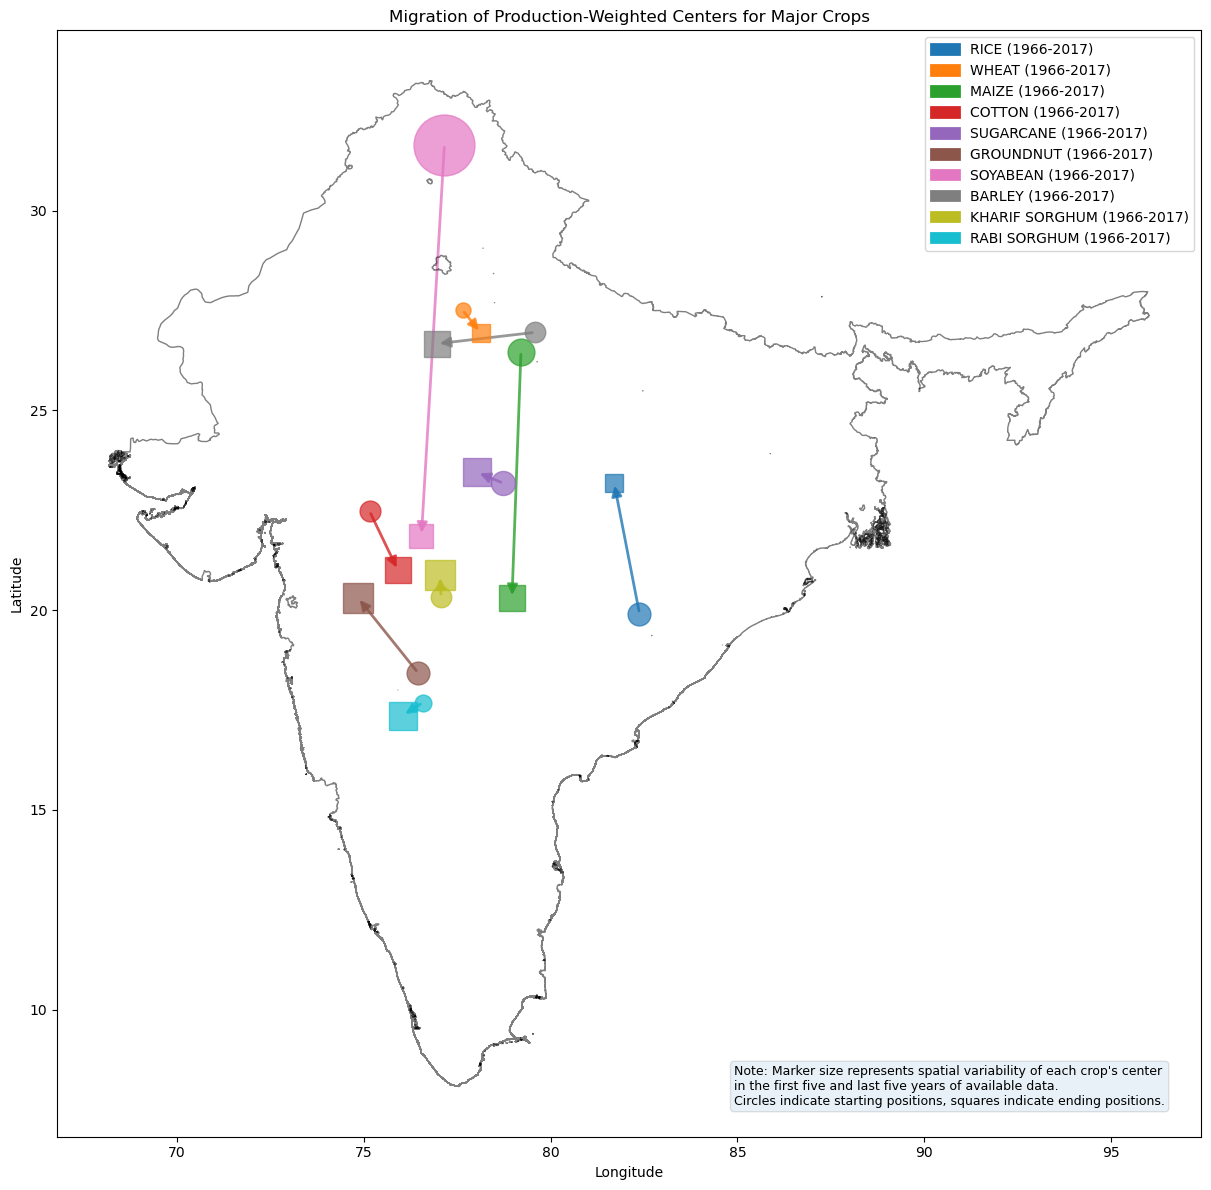

In [29]:
major_crops = ["RICE", "WHEAT", "MAIZE", "COTTON", "SUGARCANE", "GROUNDNUT", "SOYABEAN", "BARLEY", "KHARIF SORGHUM", "RABI SORGHUM"]
fig, ax = plot_multiple_crop_vectors_with_uncertainty(major_crops, weighted_centers, india_boundary)


# Crop Velocity Shifts

In [30]:
import pandas as pd
import geopandas as gpd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import FancyArrowPatch
from shapely.geometry import Point
import re
from scipy.spatial.distance import pdist, squareform

def calculate_crop_migration_velocities(weighted_centers):
    """
    Calculate migration velocities for each crop
    
    Parameters:
    weighted_centers (dict): Dictionary of GeoDataFrames with weighted centers
    
    Returns:
    dict: Dictionary with velocity metrics for each crop
    """
    velocity_data = {}
    
    for crop, df in weighted_centers.items():
        # Skip if insufficient data
        if len(df) < 2:
            continue
            
        # Sort by year
        df = df.sort_values('year')
        
        # Calculate year-to-year displacements
        df_shifted = df.shift(1)
        
        # Calculate differences between consecutive years
        df['prev_year'] = df_shifted['year']
        df['prev_lat'] = df_shifted['weighted_lat']
        df['prev_lon'] = df_shifted['weighted_lon']
        
        # Remove the first row which has NaN values
        df = df.dropna(subset=['prev_year'])
        
        # Calculate time differences in years
        df['years_diff'] = df['year'] - df['prev_year']
        
        # Calculate displacement in degrees
        df['lat_diff'] = df['weighted_lat'] - df['prev_lat']
        df['lon_diff'] = df['weighted_lon'] - df['prev_lon']
        
        # Convert to kilometers (approximate)
        # 1 degree of latitude ≈ 111 km
        # 1 degree of longitude ≈ 111 * cos(latitude) km
        df['lat_km_diff'] = df['lat_diff'] * 111
        df['lon_km_diff'] = df['lon_diff'] * 111 * np.cos(np.radians(df['weighted_lat']))
        
        # Calculate total displacement in km
        df['distance_km'] = np.sqrt(df['lat_km_diff']**2 + df['lon_km_diff']**2)
        
        # Calculate direction in degrees (0° = East, 90° = North)
        df['direction_degrees'] = np.degrees(np.arctan2(df['lat_diff'], df['lon_diff']))
        
        # Convert to compass direction
        compass_dirs = ["E", "ENE", "NE", "NNE", "N", "NNW", "NW", "WNW", 
                        "W", "WSW", "SW", "SSW", "S", "SSE", "SE", "ESE", "E"]
        df['direction'] = df['direction_degrees'].apply(
            lambda x: compass_dirs[round(((x % 360) / 22.5)) % 16]
        )
        
        # Calculate velocity in km/year
        df['velocity_km_per_year'] = df['distance_km'] / df['years_diff']
        
        # Calculate overall metrics for the entire period
        total_years = df['year'].max() - df['year'].min()
        
        # First and last points for overall displacement
        first_point = df.iloc[0][['weighted_lat', 'weighted_lon']]
        last_point = df.iloc[-1][['weighted_lat', 'weighted_lon']]
        
        # Calculate overall displacement
        lat_diff_total = last_point['weighted_lat'] - first_point['weighted_lat']
        lon_diff_total = last_point['weighted_lon'] - first_point['weighted_lon']
        
        # Convert to km
        lat_km_total = lat_diff_total * 111
        lon_km_total = lon_diff_total * 111 * np.cos(np.radians((first_point['weighted_lat'] + last_point['weighted_lat'])/2))
        
        # Total displacement and direction
        total_distance_km = np.sqrt(lat_km_total**2 + lon_km_total**2)
        total_direction_degrees = np.degrees(np.arctan2(lat_diff_total, lon_diff_total))
        total_direction = compass_dirs[round(((total_direction_degrees % 360) / 22.5)) % 16]
        
        # Overall average velocity
        avg_velocity = total_distance_km / total_years if total_years > 0 else 0
        
        # Store results
        velocity_data[crop] = {
            'start_year': df['year'].min(),
            'end_year': df['year'].max(),
            'total_years': total_years,
            'total_distance_km': total_distance_km,
            'overall_direction_degrees': total_direction_degrees,
            'overall_direction': total_direction,
            'avg_velocity_km_per_year': avg_velocity,
            'max_velocity_km_per_year': df['velocity_km_per_year'].max(),
            'min_velocity_km_per_year': df['velocity_km_per_year'].min(),
            'year_by_year_data': df,
            'start_uncertainty': 0,  # We'll update this later
            'end_uncertainty': 0     # We'll update this later
        }
        
        # Calculate uncertainty metrics
        start_uncertainty, end_uncertainty = calculate_uncertainty_metrics(weighted_centers[crop])
        velocity_data[crop]['start_uncertainty'] = start_uncertainty
        velocity_data[crop]['end_uncertainty'] = end_uncertainty
    
    return velocity_data

def generate_velocity_summary_table(velocity_data, min_years=10, sort_by='avg_velocity_km_per_year'):
    """
    Generate a summary table of crop migration velocities
    
    Parameters:
    velocity_data (dict): Dictionary with velocity metrics for each crop
    min_years (int): Minimum number of years of data required for inclusion
    sort_by (str): Column to sort by
    
    Returns:
    DataFrame: Summary table
    """
    # Extract summary data
    summary_data = []
    
    for crop, data in velocity_data.items():
        # Skip crops with insufficient data
        if data['total_years'] < min_years:
            continue
            
        summary_data.append({
            'Crop': crop,
            'Period': f"{int(data['start_year'])}-{int(data['end_year'])}",
            'Years': data['total_years'],
            'Total Displacement (km)': round(data['total_distance_km'], 1),
            'Direction': data['overall_direction'],
            'Avg Velocity (km/year)': round(data['avg_velocity_km_per_year'], 2),
            'Max Velocity (km/year)': round(data['max_velocity_km_per_year'], 2),
            'Min Velocity (km/year)': round(data['min_velocity_km_per_year'], 2),
            'Start Uncertainty': round(data['start_uncertainty'], 4),
            'End Uncertainty': round(data['end_uncertainty'], 4)
        })
    
    # Create DataFrame and sort
    summary_df = pd.DataFrame(summary_data)
    if not summary_df.empty and sort_by in summary_df.columns:
        summary_df = summary_df.sort_values(by=sort_by, ascending=False)
    
    return summary_df

def plot_crop_velocities(velocity_data, top_n=10, min_years=10):
    """
    Create a bar chart showing crop migration velocities
    
    Parameters:
    velocity_data (dict): Dictionary with velocity metrics for each crop
    top_n (int): Number of top crops to display
    min_years (int): Minimum number of years of data required for inclusion
    
    Returns:
    tuple: (fig, ax) matplotlib figure and axes
    """
    # Get summary data
    summary_df = generate_velocity_summary_table(velocity_data, min_years)
    
    # Take top N crops by velocity
    if len(summary_df) > top_n:
        plot_df = summary_df.head(top_n)
    else:
        plot_df = summary_df
    
    # Create figure
    fig, ax = plt.subplots(figsize=(12, 8))
    
    # Get data for plotting
    crops = plot_df['Crop'].values
    velocities = plot_df['Avg Velocity (km/year)'].values
    periods = plot_df['Period'].values
    
    # Create bar chart
    bars = ax.barh(crops, velocities, height=0.6)
    
    # Add value labels
    for bar in bars:
        width = bar.get_width()
        ax.text(width + 0.1, bar.get_y() + bar.get_height()/2, 
                f'{width:.2f} km/yr', va='center')
    
    # Add period annotations
    for i, (crop, period) in enumerate(zip(crops, periods)):
        ax.text(0.1, i, period, va='center', color='white', fontweight='bold')
    
    # Set labels and title
    ax.set_xlabel('Average Velocity (km/year)')
    ax.set_ylabel('Crop')
    ax.set_title(f'Top {len(plot_df)} Crops by Migration Velocity')
    
    # Set x-axis to start at 0
    ax.set_xlim(left=0)
    
    plt.tight_layout()
    return fig, ax

def plot_velocity_map(crop, velocity_data, india_boundary, weighted_centers):
    """
    Create a map showing the migration path with velocity-based coloring
    
    Parameters:
    crop (str): Crop name to plot
    velocity_data (dict): Dictionary with velocity metrics for each crop
    india_boundary (GeoDataFrame): Boundary of India for context
    weighted_centers (dict): Dictionary of GeoDataFrames with weighted centers
    
    Returns:
    tuple: (fig, ax) matplotlib figure and axes
    """
    if crop not in velocity_data:
        print(f"No velocity data available for {crop}")
        return None, None
    
    # Get year-by-year data
    df = velocity_data[crop]['year_by_year_data'].copy()
    
    # Create figure
    fig, ax = plt.subplots(figsize=(12, 10))
    
    # Plot India boundary
    india_boundary.boundary.plot(ax=ax, color='black', linewidth=1, alpha=0.5)
    
    # Plot path with velocity-based coloring
    points = []
    velocities = []
    
    # Get coordinates for line segments
    for i in range(len(df)):
        row = df.iloc[i]
        points.append((row['prev_lon'], row['prev_lat']))
        points.append((row['weighted_lon'], row['weighted_lat']))
        velocities.append(row['velocity_km_per_year'])
        velocities.append(row['velocity_km_per_year'])
    
    # Create line segments
    segments = []
    for i in range(0, len(points)-1, 2):
        segments.append([points[i], points[i+1]])
    
    # Create line collection
    from matplotlib.collections import LineCollection
    lc = LineCollection(segments, cmap='plasma', linewidth=3)
    lc.set_array(np.array(velocities[:-1]))  # Set colors based on velocities
    line = ax.add_collection(lc)
    
    # Add colorbar
    cbar = fig.colorbar(line, ax=ax)
    cbar.set_label('Velocity (km/year)')
    
    # Plot start and end points
    ax.plot(df['prev_lon'].iloc[0], df['prev_lat'].iloc[0], 'go', markersize=10, label=f"Start ({int(df['prev_year'].iloc[0])})")
    ax.plot(df['weighted_lon'].iloc[-1], df['weighted_lat'].iloc[-1], 'ro', markersize=10, label=f"End ({int(df['year'].iloc[-1])})")
    
    # Add year labels at each point
    for i, row in df.iterrows():
        ax.text(row['weighted_lon'], row['weighted_lat'], str(int(row['year'])), 
                fontsize=8, ha='right', va='bottom')
    
    # Set title and labels
    ax.set_title(f"Migration of {crop} Production Center with Velocity Indicators")
    ax.set_xlabel('Longitude')
    ax.set_ylabel('Latitude')
    plt.legend()
    
    plt.tight_layout()
    return fig, ax

                    Crop     Period  Years  Total Displacement (km) Direction  \
0                   RICE  1967-2017     50                    297.5       NNW   
1                  WHEAT  1967-2017     50                     49.6        SE   
2         KHARIF SORGHUM  1967-2017     50                     33.3       NNE   
3           RABI SORGHUM  1967-2017     50                     61.4        SW   
4                SORGHUM  1967-2017     50                    100.7       SSW   
5           PEARL MILLET  1967-2017     50                    211.0       NNE   
6                  MAIZE  1967-2017     50                    640.1         S   
7          FINGER MILLET  1967-2017     50                    181.9        SW   
8                 BARLEY  1967-2017     50                    245.4         W   
9               CHICKPEA  1967-2017     50                    521.6         S   
10             PIGEONPEA  1967-2017     50                    296.9       SSW   
11          MINOR PULSES  19

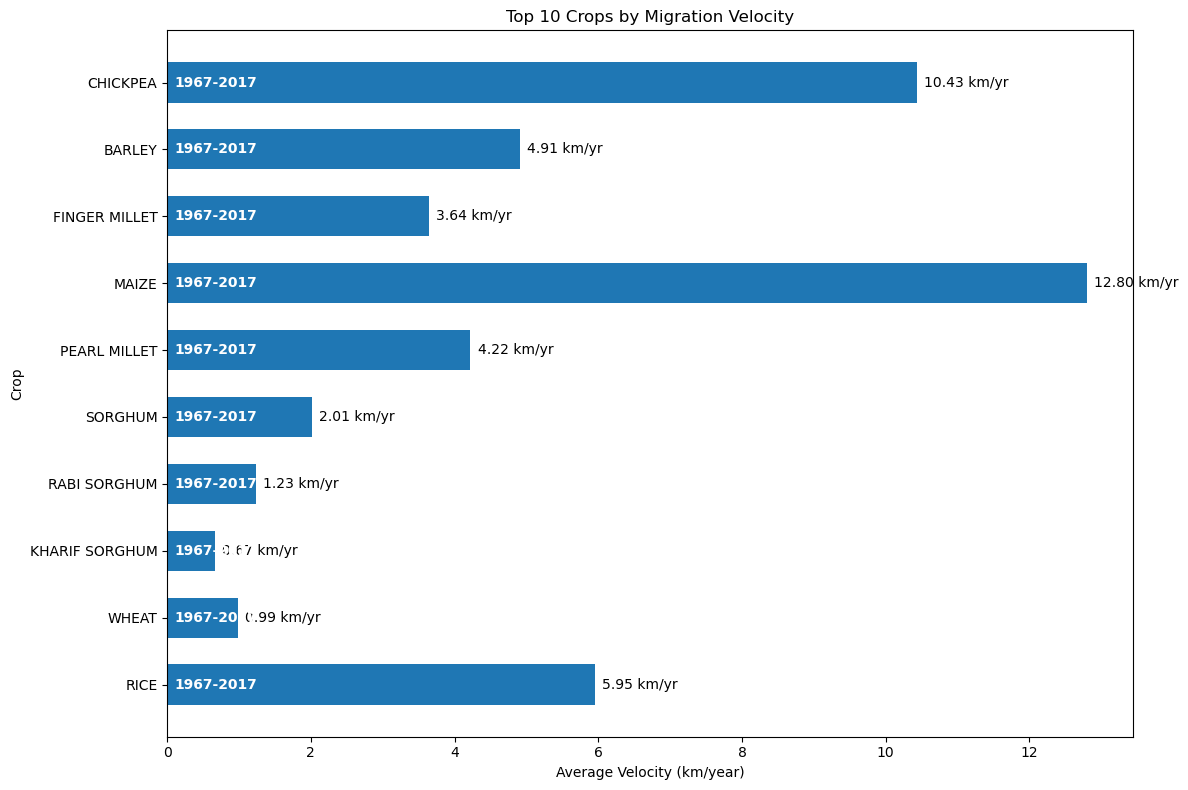

In [31]:
# Code to run the analysis
# First, calculate velocities
velocity_data = calculate_crop_migration_velocities(weighted_centers)

# Generate summary table
summary_table = generate_velocity_summary_table(velocity_data)
print(summary_table)

# Plot top crops by velocity
fig, ax = plot_crop_velocities(velocity_data)
plt.show()

# Correlation Matrix Between Yields in Crops

In [32]:
import pandas as pd
import geopandas as gpd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
import matplotlib.gridspec as gridspec
from scipy import stats
from sklearn.linear_model import LinearRegression

def detrend_yields_and_calculate_correlations(gdf, crops=['RICE', 'WHEAT']):
    """
    Detrend yield data and calculate correlations between yield anomalies for each district
    
    Parameters:
    gdf (GeoDataFrame): GeoDataFrame with district geometries and crop data
    crops (list): List of crop names to analyze
    
    Returns:
    GeoDataFrame: Original geodataframe with added correlation columns
    """
    # Get unique districts
    districts = gdf['Dist Code'].unique()
    
    # Create columns for correlations
    for i, crop1 in enumerate(crops):
        for j, crop2 in enumerate(crops):
            # Only calculate once per pair (and for self-correlations)
            if i <= j:
                col_name = f"{crop1}_{crop2}_ANOMALY_CORR"
                gdf[col_name] = np.nan
    
    # Calculate detrended correlations for each district
    for district in districts:
        # Filter data for this district
        district_data = gdf[gdf['Dist Code'] == district].copy()
        
        # Skip if we don't have enough years for this district
        if len(district_data) < 7:  # Need more data for reliable detrending
            continue
        
        # Sort by year
        district_data = district_data.sort_values('Year')
        
        # Detrend each crop's yield
        for crop in crops:
            yield_col = f"{crop} YIELD (Kg per ha)"
            anomaly_col = f"{crop}_YIELD_ANOMALY"
            
            # Skip if this crop data is not available
            if yield_col not in district_data.columns:
                continue
                
            # Check if we have enough valid data points
            valid_data = district_data.dropna(subset=[yield_col])
            if len(valid_data) < 7:
                continue
                
            # Extract years and yields for regression
            X = valid_data['Year'].values.reshape(-1, 1)
            y = valid_data[yield_col].values
            
            # Fit linear trend
            model = LinearRegression()
            model.fit(X, y)
            
            # Calculate trend and anomaly
            trend = model.predict(X)
            anomalies = y - trend
            
            # Store anomalies in the dataframe
            for idx, anomaly in zip(valid_data.index, anomalies):
                district_data.loc[idx, anomaly_col] = anomaly
        
        # Calculate correlations between detrended yields
        for i, crop1 in enumerate(crops):
            for j, crop2 in enumerate(crops):
                # Only calculate once per pair (and for self-correlations)
                if i <= j:
                    # Get anomaly columns
                    crop1_anomaly_col = f"{crop1}_YIELD_ANOMALY"
                    crop2_anomaly_col = f"{crop2}_YIELD_ANOMALY"
                    
                    # Skip if either column is missing
                    if crop1_anomaly_col not in district_data.columns or crop2_anomaly_col not in district_data.columns:
                        continue
                    
                    # Filter out rows with missing anomalies
                    valid_data = district_data.dropna(subset=[crop1_anomaly_col, crop2_anomaly_col])
                    
                    # Skip if not enough valid data points
                    if len(valid_data) < 5:
                        continue
                    
                    # Calculate correlation
                    correlation, _ = stats.pearsonr(
                        valid_data[crop1_anomaly_col], 
                        valid_data[crop2_anomaly_col]
                    )
                    
                    # Create column name for this correlation
                    col_name = f"{crop1}_{crop2}_ANOMALY_CORR"
                    
                    # Store correlation value in the original geodataframe
                    # We'll use the most recent year's row for this district
                    latest_year_idx = district_data['Year'].idxmax()
                    gdf.loc[latest_year_idx, col_name] = correlation
    
    return gdf

import pandas as pd
import geopandas as gpd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
import matplotlib.gridspec as gridspec
from scipy import stats
from sklearn.linear_model import LinearRegression
import matplotlib as mpl

def plot_spatial_anomaly_correlation_matrix(gdf, crops=['RICE', 'WHEAT']):
    """
    Plot a grid of maps showing spatial correlations between detrended crop yields
    with a single colorbar at the bottom
    
    Parameters:
    gdf (GeoDataFrame): GeoDataFrame with district geometries and correlations
    crops (list): List of crop names to visualize
    
    Returns:
    matplotlib.figure.Figure: The figure object
    """
    # Create a figure with a grid of subplots
    fig = plt.figure(figsize=(18, 16))
    
    # Create a more complex gridspec with space for the colorbar
    gs = gridspec.GridSpec(len(crops), len(crops), figure=fig, 
                          height_ratios=[1] * (len(crops)-1) + [0.1],
                          width_ratios=[1] * (len(crops)-1) + [0.1])
    
    # Create a diverging colormap (brown to green)
    cmap = LinearSegmentedColormap.from_list(
        'brown_green_cmap', ['#8B4513', '#F5F5DC', '#006400'])
    
    # Create a geodataframe with just the most recent year for each district
    latest_gdf = gdf.loc[gdf.groupby('Dist Code')['Year'].idxmax()]
    
    # Create a norm for consistent color scaling across all maps
    norm = mpl.colors.Normalize(vmin=-1, vmax=1)
    
    # Create subplots for each crop pair
    for i, crop1 in enumerate(crops):
        for j, crop2 in enumerate(crops):

            if j>=i:
                print(f"Skipping {crop2} vs {crop1}")
                continue

            # Create subplot
            ax = fig.add_subplot(gs[i-1, j])
            
            # Get correlation column
            if i <= j:
                corr_col = f"{crop1}_{crop2}_ANOMALY_CORR"
            else:
                corr_col = f"{crop2}_{crop1}_ANOMALY_CORR"
            
            # Plot map without individual legends
            latest_gdf.plot(
                figsize=(5,5),
                column=corr_col,
                cmap=cmap,
                linewidth=0.1,
                ax=ax,
                edgecolor='gray',
                norm=norm,
                legend=False
            )
            
            # Set title
            ax.set_title(f"{crop1} vs {crop2}", fontsize=12)
            
            # Remove axis labels
            ax.set_xticks([])
            ax.set_yticks([])
            
            # Add crop labels on the sides
            if j == 0:
                ax.text(-0.15, 0.5, crop1, transform=ax.transAxes, 
                        rotation=90, ha='center', va='center', fontsize=18)
            if i == 0:
                ax.text(0.5, 1.15, crop2, transform=ax.transAxes,
                        ha='center', va='center', fontsize=18)
    
    # Add a single colorbar at the bottom that spans all columns
    cbar_ax = fig.add_subplot(gs[-1, :])
    cb = mpl.colorbar.ColorbarBase(
        cbar_ax, 
        cmap=cmap,
        norm=norm,
        orientation='horizontal',
        label='Correlation of Yield Anomalies'
    )

    # Get the total bounds of the entire geodataframe
    bounds = latest_gdf.total_bounds
    x_min, y_min, x_max, y_max = bounds

    # Set these bounds for all subplot axes
    for ax in fig.get_axes():
        # Skip the colorbar axis
        if ax == cbar_ax:
            continue
            
        ax.set_xlim(x_min, x_max)
        ax.set_ylim(y_min, y_max)

    plt.suptitle('Spatial Correlation of Detrended Crop Yield Anomalies by District', fontsize=16)
    plt.tight_layout(rect=[0, 0, 1, 0.96])
    
    return fig

# Expanded version for multiple crops with single colorbar
# def plot_multi_crop_spatial_correlation_matrix(gdf, crops):
#     """
#     Plot a grid of maps showing spatial correlations between multiple crop yields
#     with a single colorbar at the bottom
    
#     Parameters:
#     gdf (GeoDataFrame): GeoDataFrame with district geometries and correlations
#     crops (list): List of crop names to visualize
    
#     Returns:
#     matplotlib.figure.Figure: The figure object
#     """
#     # Create a figure with a grid of subplots
#     fig = plt.figure(figsize=(4 * len(crops), 4 * len(crops) + 0.5))
    
#     # Create a more complex gridspec with space for the colorbar
#     gs = gridspec.GridSpec(len(crops) + 1, len(crops), figure=fig, 
#                           height_ratios=[1] * len(crops) + [0.1])
    
#     # Create a diverging colormap (red to white to blue)
#     cmap = LinearSegmentedColormap.from_list(
#         'corr_cmap', ['#d7191c', '#ffffff', '#2c7bb6'])
    
#     # Create a geodataframe with just the most recent year for each district
#     latest_gdf = gdf.loc[gdf.groupby('Dist Code')['Year'].idxmax()]
    
#     # Create a norm for consistent color scaling across all maps
#     norm = mpl.colors.Normalize(vmin=-1, vmax=1)
    
#     # Create subplots for each crop pair
#     for i, crop1 in enumerate(crops):
#         for j, crop2 in enumerate(crops):
#             # Create subplot
#             if i>=j:
#                 print(f"Skipping {crop1} vs {crop2}")
#                 continue
#             ax = fig.add_subplot(gs[i, j])
            
#             # Get correlation column
#             if i <= j:
#                 corr_col = f"{crop1}_{crop2}_ANOMALY_CORR"
#             else:
#                 corr_col = f"{crop2}_{crop1}_ANOMALY_CORR"
            
#             # Plot map without individual legends
#             latest_gdf.plot(
#                 column=corr_col,
#                 cmap=cmap,
#                 linewidth=0.1,
#                 ax=ax,
#                 edgecolor='gray',
#                 norm=norm,
#                 legend=False
#             )
            
#             # Set title
#             ax.set_title(f"{crop1} vs {crop2}", fontsize=10)
            
#             # Remove axis labels
#             ax.set_xticks([])
#             ax.set_yticks([])
            
#             # Add crop labels on the sides
#             if j == 0:
#                 ax.text(-0.15, 0.5, crop1, transform=ax.transAxes, 
#                         rotation=90, ha='center', va='center', fontsize=12)
#             if i == 0:
#                 ax.text(0.5, 1.5, crop2, transform=ax.transAxes,
#                         ha='center', va='center', fontsize=12)
    
#     # Add a single colorbar at the bottom that spans all columns
#     cbar_ax = fig.add_subplot(gs[-1, :])
#     cb = mpl.colorbar.ColorbarBase(
#         cbar_ax, 
#         cmap=cmap,
#         norm=norm,
#         orientation='horizontal',
#         label='Correlation of Yield Anomalies'
#     )
    
#     plt.suptitle('Spatial Correlation of Detrended Crop Yield Anomalies by District', fontsize=16)
#     plt.tight_layout(rect=[0, 0, 1, 0.96])
    
#     return fig

In [33]:
def plot_yield_detrending_example(gdf, district_code, crop):
    """
    Plot an example of yield detrending for a specific district and crop
    
    Parameters:
    gdf (GeoDataFrame): GeoDataFrame with district geometries and crop data
    district_code: Code for the district to visualize
    crop (str): Crop name to visualize
    
    Returns:
    matplotlib.figure.Figure: The figure object
    """
    # Filter data for this district
    district_data = gdf[gdf['Dist Code'] == district_code].copy()
    
    # Get district name
    district_name = district_data['Dist Name'].iloc[0]
    
    # Sort by year
    district_data = district_data.sort_values('Year')
    
    # Get yield column
    yield_col = f"{crop} YIELD (Kg per ha)"
    
    # Skip if this crop data is not available
    if yield_col not in district_data.columns:
        return None
        
    # Check if we have enough valid data points
    valid_data = district_data.dropna(subset=[yield_col])
    if len(valid_data) < 7:
        return None
        
    # Extract years and yields for regression
    X = valid_data['Year'].values.reshape(-1, 1)
    years = valid_data['Year'].values
    y = valid_data[yield_col].values
    
    # Fit linear trend
    model = LinearRegression()
    model.fit(X, y)
    
    # Calculate trend and anomaly
    trend = model.predict(X)
    anomalies = y - trend
    
    # Create figure
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 10))
    
    # Plot raw yield and trend
    ax1.scatter(years, y, label='Actual Yield', color='blue')
    ax1.plot(years, trend, label='Trend', color='red', linestyle='--')
    ax1.set_title(f"{crop} Yield and Trend in {district_name}")
    ax1.set_xlabel('Year')
    ax1.set_ylabel('Yield (Kg/ha)')
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    
    # Plot anomalies
    ax2.bar(years, anomalies, label='Yield Anomalies', color='green')
    ax2.axhline(y=0, color='black', linestyle='-', alpha=0.3)
    ax2.set_title(f"{crop} Yield Anomalies in {district_name}")
    ax2.set_xlabel('Year')
    ax2.set_ylabel('Yield Anomaly (Kg/ha)')
    ax2.grid(True, alpha=0.3)
    
    plt.tight_layout()
    return fig

/var/folders/16/y9h7_0ld1418y9zts1sf_3xh0000gn/T/ipykernel_47777/1278944636.py:95: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlation, _ = stats.pearsonr(
/var/folders/16/y9h7_0ld1418y9zts1sf_3xh0000gn/T/ipykernel_47777/1278944636.py:95: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlation, _ = stats.pearsonr(
/var/folders/16/y9h7_0ld1418y9zts1sf_3xh0000gn/T/ipykernel_47777/1278944636.py:95: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlation, _ = stats.pearsonr(
/var/folders/16/y9h7_0ld1418y9zts1sf_3xh0000gn/T/ipykernel_47777/1278944636.py:95: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlation, _ = stats.pearsonr(
/var/folders/16/y9h7_0ld1418y9zts1sf_3xh0000gn/T/ipykernel_47777/1278944636.py:95: ConstantInputWarning: An input array is constant; the correlation coe

Skipping RICE vs RICE
Skipping WHEAT vs RICE
Skipping MAIZE vs RICE
Skipping KHARIF SORGHUM vs RICE
Skipping RABI SORGHUM vs RICE
Skipping WHEAT vs WHEAT
Skipping MAIZE vs WHEAT
Skipping KHARIF SORGHUM vs WHEAT
Skipping RABI SORGHUM vs WHEAT
Skipping MAIZE vs MAIZE
Skipping KHARIF SORGHUM vs MAIZE
Skipping RABI SORGHUM vs MAIZE
Skipping KHARIF SORGHUM vs KHARIF SORGHUM
Skipping RABI SORGHUM vs KHARIF SORGHUM
Skipping RABI SORGHUM vs RABI SORGHUM


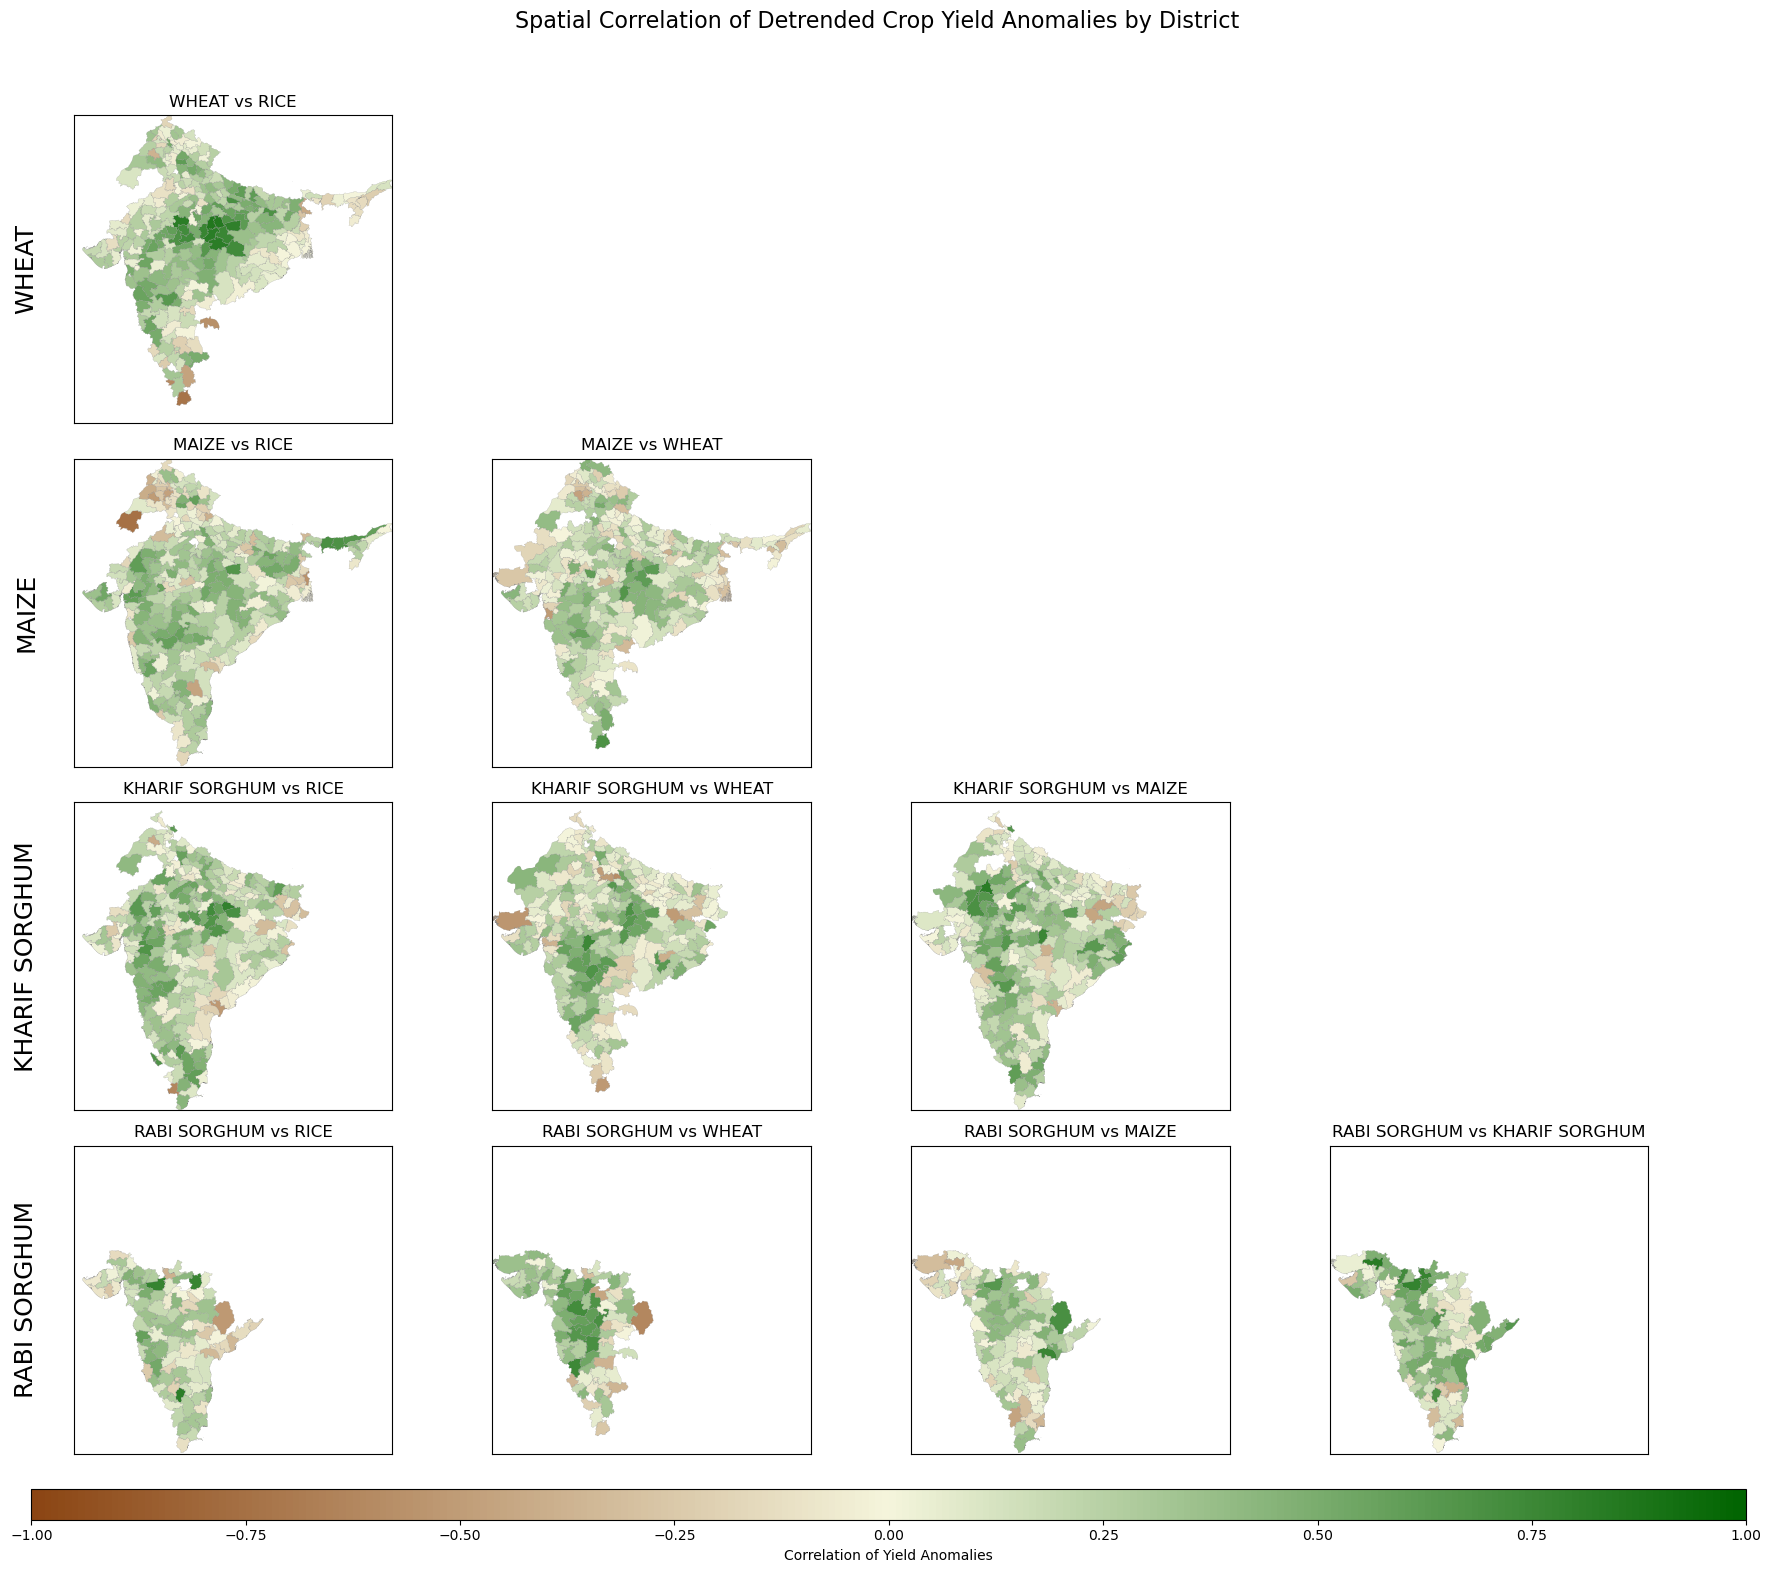

In [34]:
#Example usage:
# Calculate correlations for detrended yields
gdf_with_anomaly_corr = detrend_yields_and_calculate_correlations(filtered_gdf, crops=['RICE', 'WHEAT', 'MAIZE', 'KHARIF SORGHUM', 'RABI SORGHUM'])

# Plot spatial correlation matrix for anomalies
fig = plot_spatial_anomaly_correlation_matrix(gdf_with_anomaly_corr, crops=['RICE', 'WHEAT', 'MAIZE', 'KHARIF SORGHUM', 'RABI SORGHUM'])
plt.savefig(plot_path+'crop_anomaly_correlation_matrix.png', dpi=300, bbox_inches='tight')
plt.show()

# Example of detrending for a specific district and crop
# First, find a district with good data
# sample_district = merged['Dist Code'].iloc[0]  # Just an example
# fig = plot_yield_detrending_example(merged, sample_district, 'RICE')
# plt.savefig(plot_path+'rice_detrending_example.png', dpi=300, bbox_inches='tight')
# plt.show()

# Yield Anomaly Strength Over Time

In [35]:
import pandas as pd
import geopandas as gpd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
import seaborn as sns
from scipy import stats
from sklearn.linear_model import LinearRegression

def calculate_anomaly_magnitude_trends(gdf, crops):
    """
    Calculate trends in the magnitude of yield anomalies over time for each district and crop
    
    Parameters:
    gdf (GeoDataFrame): GeoDataFrame with district geometries and crop data
    crops (list): List of crop names to analyze
    
    Returns:
    GeoDataFrame: Original geodataframe with added trend columns
    """
    # Get unique districts
    districts = gdf['Dist Code'].unique()
    
    # Create columns for anomaly magnitude trends
    for crop in crops:
        trend_col = f"{crop}_ANOMALY_MAGNITUDE_TREND"
        gdf[trend_col] = np.nan
        
        # Also add a column for the p-value of the trend
        pvalue_col = f"{crop}_ANOMALY_MAGNITUDE_PVALUE"
        gdf[pvalue_col] = np.nan
        
        # Add a column for average relative anomaly magnitude
        avg_col = f"{crop}_AVG_REL_ANOMALY_MAGNITUDE"
        gdf[avg_col] = np.nan
    
    # Calculate trends for each district and crop
    for district in districts:
        # Filter data for this district
        district_data = gdf[gdf['Dist Code'] == district].copy()
        
        # Skip if we don't have enough years for this district
        if len(district_data) < 7:  # Need sufficient data for reliable trend analysis
            continue
        
        # Sort by year
        district_data = district_data.sort_values('Year')
        
        # Process each crop
        for crop in crops:
            yield_col = f"{crop} YIELD (Kg per ha)"
            
            # Skip if this crop data is not available
            if yield_col not in district_data.columns:
                continue
                
            # Check if we have enough valid data points
            valid_data = district_data.dropna(subset=[yield_col])
            if len(valid_data) < 7:
                continue
                
            # Extract years and yields for regression
            X = valid_data['Year'].values.reshape(-1, 1)
            y = valid_data[yield_col].values
            
            # Fit linear trend to get the expected yields
            model = LinearRegression()
            model.fit(X, y)
            
            # Calculate trend and anomaly
            trend = model.predict(X)
            anomalies = y - trend
            
            # Calculate relative anomaly magnitudes (absolute value as percent of trend)
            rel_anomaly_magnitudes = np.abs(anomalies / trend) * 100
            
            # Store relative anomaly magnitudes in a temporary column
            valid_data['rel_anomaly_magnitude'] = rel_anomaly_magnitudes
            
            # Calculate average relative anomaly magnitude
            avg_magnitude = np.mean(rel_anomaly_magnitudes)
            
            # Now fit a trend to these relative anomaly magnitudes over time
            X_trend = valid_data['Year'].values.reshape(-1, 1)
            y_trend = valid_data['rel_anomaly_magnitude'].values
            
            # Use scipy's linregress for slope and p-value
            slope, intercept, r_value, p_value, std_err = stats.linregress(
                valid_data['Year'], valid_data['rel_anomaly_magnitude']
            )
            
            # Store results in the original geodataframe
            # We'll use the most recent year's row for this district
            latest_year_idx = district_data['Year'].idxmax()
            
            # Store the trend (slope coefficient)
            trend_col = f"{crop}_ANOMALY_MAGNITUDE_TREND"
            gdf.loc[latest_year_idx, trend_col] = slope
            
            # Store the p-value
            pvalue_col = f"{crop}_ANOMALY_MAGNITUDE_PVALUE"
            gdf.loc[latest_year_idx, pvalue_col] = p_value
            
            # Store the average relative anomaly magnitude
            avg_col = f"{crop}_AVG_REL_ANOMALY_MAGNITUDE"
            gdf.loc[latest_year_idx, avg_col] = avg_magnitude
    
    return gdf

def plot_anomaly_magnitude_trends(gdf, crop, significance_threshold=0.1):
    """
    Plot a map of trends in yield anomaly magnitudes for a specific crop
    
    Parameters:
    gdf (GeoDataFrame): GeoDataFrame with district geometries and anomaly magnitude trends
    crop (str): Crop name to visualize
    significance_threshold (float): P-value threshold for statistical significance
    
    Returns:
    matplotlib.figure.Figure: The figure object
    """
    # Create a geodataframe with just the most recent year for each district
    latest_gdf = gdf.loc[gdf.groupby('Dist Code')['Year'].idxmax()]
    
    # Get the trend and p-value columns
    trend_col = f"{crop}_ANOMALY_MAGNITUDE_TREND"
    pvalue_col = f"{crop}_ANOMALY_MAGNITUDE_PVALUE"
    
    # Check if columns exist
    if trend_col not in latest_gdf.columns or pvalue_col not in latest_gdf.columns:
        print(f"Warning: Required columns for {crop} not found in data")
        return None
    
    # Create a mask for statistically significant trends
    latest_gdf['significant'] = latest_gdf[pvalue_col] <= significance_threshold
    
    # Create a diverging colormap (brown to white to green)
    cmap = LinearSegmentedColormap.from_list(
        'brown_green_cmap', ['#8B4513', '#F5F5DC', '#006400'])
    
    # Create figure and axes
    fig, ax = plt.subplots(figsize=(14, 10))
    
    # Find the maximum absolute value for symmetric color scaling
    max_abs_value = latest_gdf[trend_col].abs().max()
    
    # Plot all districts with color based on trend
    latest_gdf.plot(
        column=trend_col,
        cmap=cmap,
        linewidth=0.1,
        ax=ax,
        edgecolor='gray',
        vmin=-5,
        vmax=5,
        legend=True,
        legend_kwds={'label': 'Trend in Anomaly Magnitude (% change per year)', 
                     'orientation': 'horizontal'}
    )
    
    # Highlight districts with statistically significant trends
    significant_districts = latest_gdf[latest_gdf['significant']]
    significant_districts.boundary.plot(
        ax=ax, 
        linewidth=1.0, 
        edgecolor='black'
    )
    
    # Set title and labels
    ax.set_title(f"Trend in {crop} Yield Anomaly Magnitude (% per Year)", fontsize=16)
    ax.set_xticks([])
    ax.set_yticks([])
    
    # Add a note about significance
    plt.figtext(0.3, 0.25, 
                f"Note: Districts with bold boundaries have statistically significant trends (p ≤ {significance_threshold})",
                ha='left', fontsize=10, bbox=dict(boxstyle='round', alpha=0.1))
    
    plt.tight_layout()
    return fig

def plot_anomaly_example(gdf, district_code, crop):
    """
    Plot an example of yield trend, anomalies, and anomaly magnitude trend for a specific district and crop
    
    Parameters:
    gdf (GeoDataFrame): GeoDataFrame with district geometries and crop data
    district_code: Code for the district to visualize
    crop (str): Crop name to visualize
    
    Returns:
    matplotlib.figure.Figure: The figure object
    """
    # Filter data for this district
    district_data = gdf[gdf['Dist Code'] == district_code].copy()
    
    # Get district name
    district_name = district_data['Dist Name'].iloc[0]
    
    # Sort by year
    district_data = district_data.sort_values('Year')
    
    # Get yield column
    yield_col = f"{crop} YIELD (Kg per ha)"
    
    # Skip if this crop data is not available
    if yield_col not in district_data.columns:
        return None
        
    # Check if we have enough valid data points
    valid_data = district_data.dropna(subset=[yield_col])
    if len(valid_data) < 7:
        return None
        
    # Extract years and yields for regression
    X = valid_data['Year'].values.reshape(-1, 1)
    years = valid_data['Year'].values
    y = valid_data[yield_col].values
    
    # Fit linear trend
    model = LinearRegression()
    model.fit(X, y)
    
    # Calculate trend and anomaly
    trend = model.predict(X)
    anomalies = y - trend
    
    # Calculate relative anomaly magnitudes (absolute value as percent of trend)
    rel_anomaly_magnitudes = np.abs(anomalies / trend) * 100
    
    # Fit trend to anomaly magnitudes
    slope, intercept, r_value, p_value, std_err = stats.linregress(
        years, rel_anomaly_magnitudes
    )
    magnitude_trend = intercept + slope * years
    
    # Create figure with 3 subplots
    fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(12, 15))
    
    # Plot 1: Raw yield and trend
    ax1.scatter(years, y, label='Actual Yield', color='blue')
    ax1.plot(years, trend, label='Trend', color='red', linestyle='--')
    ax1.set_title(f"{crop} Yield and Trend in {district_name}")
    ax1.set_xlabel('Year')
    ax1.set_ylabel('Yield (Kg/ha)')
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    
    # Plot 2: Yield anomalies
    ax2.bar(years, anomalies, label='Yield Anomalies', color='green')
    ax2.axhline(y=0, color='black', linestyle='-', alpha=0.3)
    ax2.set_title(f"{crop} Yield Anomalies in {district_name}")
    ax2.set_xlabel('Year')
    ax2.set_ylabel('Yield Anomaly (Kg/ha)')
    ax2.grid(True, alpha=0.3)
    
    # Plot 3: Relative anomaly magnitudes and trend
    ax3.bar(years, rel_anomaly_magnitudes, label='Relative Anomaly Magnitude', color='purple')
    ax3.plot(years, magnitude_trend, label=f'Trend (slope={slope:.4f}, p={p_value:.4f})', color='orange', linestyle='--')
    ax3.set_title(f"{crop} Relative Anomaly Magnitudes in {district_name}")
    ax3.set_xlabel('Year')
    ax3.set_ylabel('Relative Anomaly Magnitude (%)')
    ax3.legend()
    ax3.grid(True, alpha=0.3)
    
    plt.tight_layout()
    return fig

def plot_multi_crop_anomaly_trends(gdf, crops, significance_threshold=0.1):
    """
    Plot maps of trends in yield anomaly magnitudes for multiple crops
    
    Parameters:
    gdf (GeoDataFrame): GeoDataFrame with district geometries and anomaly magnitude trends
    crops (list): List of crop names to visualize
    significance_threshold (float): P-value threshold for statistical significance
    
    Returns:
    matplotlib.figure.Figure: The figure object
    """
    # Calculate number of rows and columns for subplots
    n_crops = len(crops)
    n_cols = min(3, n_crops)  # Maximum 3 columns
    n_rows = (n_crops + n_cols - 1) // n_cols  # Ceiling division
    
    # Create a geodataframe with just the most recent year for each district
    latest_gdf = gdf.loc[gdf.groupby('Dist Code')['Year'].idxmax()]
    
    # Create a diverging colormap (brown to white to green)
    cmap = LinearSegmentedColormap.from_list(
        'brown_green_cmap', ['#8B4513', '#F5F5DC', '#006400'])
    
    # Create figure
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(6 * n_cols, 5 * n_rows))
    
    # Flatten axes array for easier indexing if there are multiple rows
    if n_rows > 1:
        axes = axes.flatten()
    
    # Find the maximum absolute value across all crops for consistent color scaling
    max_abs_value = 0
    for i, crop in enumerate(crops):
        trend_col = f"{crop}_ANOMALY_MAGNITUDE_TREND"
        if trend_col in latest_gdf.columns:
            max_abs_value = max(max_abs_value, latest_gdf[trend_col].abs().max())
    
    # Plot each crop
    for i, crop in enumerate(crops):
        # Skip if we have more axes than crops
        if i >= len(axes):
            break
            
        # Get current axis
        ax = axes[i] if n_rows > 1 or n_cols > 1 else axes
        
        # Get the trend and p-value columns
        trend_col = f"{crop}_ANOMALY_MAGNITUDE_TREND"
        pvalue_col = f"{crop}_ANOMALY_MAGNITUDE_PVALUE"
        
        # Check if columns exist
        if trend_col not in latest_gdf.columns or pvalue_col not in latest_gdf.columns:
            ax.text(0.5, 0.5, f"No data available for {crop}", 
                    ha='center', va='center', transform=ax.transAxes)
            ax.set_xticks([])
            ax.set_yticks([])
            continue
        
        # Create a mask for statistically significant trends
        latest_gdf['significant'] = latest_gdf[pvalue_col] <= significance_threshold
        
        # Plot all districts with color based on trend
        latest_gdf.plot(
            column=trend_col,
            cmap=cmap,
            linewidth=0.1,
            ax=ax,
            edgecolor='gray',
            vmin=-max_abs_value,
            vmax=max_abs_value,
            legend=True if i == 0 else False  # Only show legend for first plot
        )
        
        # Highlight districts with statistically significant trends
        significant_districts = latest_gdf[latest_gdf['significant']]
        significant_districts.boundary.plot(
            ax=ax, 
            linewidth=1.0, 
            edgecolor='black'
        )
        
        # Set title and labels
        ax.set_title(f"{crop}", fontsize=14)
        ax.set_xticks([])
        ax.set_yticks([])
    
    # Hide any unused subplots
    for i in range(len(crops), len(axes)):
        if n_rows > 1 or n_cols > 1:
            fig.delaxes(axes[i])
    
    # Add a colorbar for all subplots
    if n_rows > 1 or n_cols > 1:
        fig.subplots_adjust(right=0.9)
        cbar_ax = fig.add_axes([0.92, 0.15, 0.02, 0.7])
        sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(-max_abs_value, max_abs_value))
        sm.set_array([])
        cbar = fig.colorbar(sm, cax=cbar_ax)
        cbar.set_label('Trend in Anomaly Magnitude (% change per year)')
        sm.set_clim(-50, 50)
    
    plt.suptitle('Trends in Crop Yield Anomaly Magnitudes by District', fontsize=16)
    
    # Add a note about significance
    plt.figtext(0.6, 0.2, 
                f"Note: Districts with bold boundaries have statistically significant trends (p ≤ {significance_threshold})",
                ha='center', fontsize=10, bbox=dict(boxstyle='round', alpha=0.1))
    
    plt.tight_layout(rect=[0, 0.05, 0.9 if (n_rows > 1 or n_cols > 1) else 1, 0.95])
    return fig

/Users/michaelfoley/miniforge3/envs/pygeo/lib/python3.13/site-packages/geopandas/geodataframe.py:1819: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
/Users/michaelfoley/miniforge3/envs/pygeo/lib/python3.13/site-packages/geopandas/geodataframe.py:1819: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
/Users/michaelfoley/miniforge3/envs/pygeo/lib/python3.13/site-packages/geopandas/geodataframe.py:1819: SettingWithCopyWarning: 
A value is trying to b

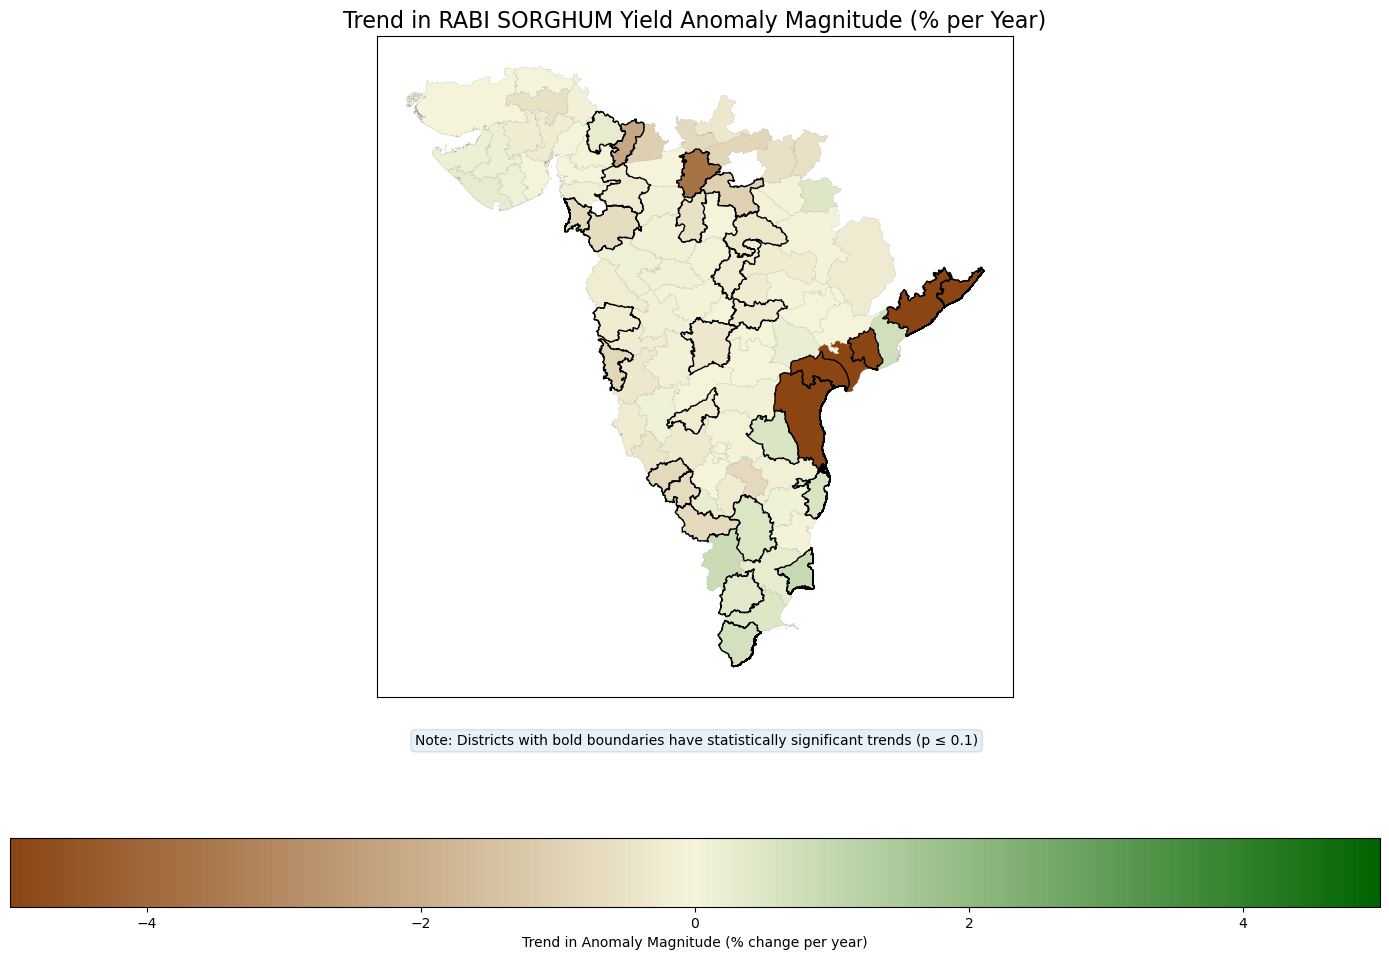

In [36]:
# Calculate anomaly magnitude trends
gdf_with_trends = calculate_anomaly_magnitude_trends(filtered_gdf, crops=['RABI SORGHUM'])

# Plot trend for a single crop
fig = plot_anomaly_magnitude_trends(gdf_with_trends, 'RABI SORGHUM')
plt.savefig(plot_path+'rabi_sorghum_anomaly_magnitude_trend.png', dpi=300, bbox_inches='tight')

# Plot example for a specific district
# sample_district = filtered_gdf[filtered_gdf['Dist_Name'] == 'Firozpur']['Dist Code'].iloc[0]  # Just an example
# fig = plot_anomaly_example(gdf_with_trends, sample_district, 'WHEAT')
# plt.savefig(plot_path+'maize_anomaly_example.png', dpi=300, bbox_inches='tight')

# # Plot trends for multiple crops
# fig = plot_multi_crop_anomaly_trends(gdf_with_trends, crops=['RICE', 'WHEAT', 'MAIZE', 'COTTON'])
# plt.savefig('multi_crop_anomaly_trends.png', dpi=300, bbox_inches='tight')

# Great - now let's look at correlation between irrigation and yield variability

In [37]:
irrigation = pd.read_csv('/Users/michaelfoley/Library/CloudStorage/GoogleDrive-mfoley@g.harvard.edu/My Drive/Subnational_Yield_Database/data/processed/IND/icrisat_apportioned/ICRISAT-District Level Irrigation Data.csv')

In [38]:
import pandas as pd
import geopandas as gpd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
import seaborn as sns
from scipy import stats
from sklearn.linear_model import LinearRegression

def load_and_merge_irrigation_data(gdf, irrigation_file_path):
    """
    Load irrigation data and merge with the existing geodataframe
    
    Parameters:
    gdf (GeoDataFrame): Existing geodataframe with crop data
    irrigation_file_path (str): Path to the irrigation data CSV
    
    Returns:
    GeoDataFrame: Merged geodataframe with irrigation data
    """
    # Load irrigation data
    irrigation_df = pd.read_csv(irrigation_file_path)
    
    # Merge with the existing geodataframe
    # Use a left join to keep all rows from the original geodataframe
    merged_gdf = gdf.merge(irrigation_df, on=['Dist Code', 'Year', 'State Code', 'State Name', 'Dist Name'], 
                          how='left', suffixes=('', '_IRR'))
    
    return merged_gdf

def calculate_irrigation_metrics(gdf, crops):
    """
    Calculate irrigation metrics for each district and crop
    
    Parameters:
    gdf (GeoDataFrame): GeoDataFrame with district geometries, crop and irrigation data
    crops (list): List of crop names to analyze
    
    Returns:
    GeoDataFrame: Original geodataframe with added irrigation metrics
    """
    # Get unique districts
    districts = gdf['Dist Code'].unique()
    
    # Create columns for irrigation metrics
    for crop in crops:
        # Average irrigation percentage column
        avg_irr_col = f"{crop}_AVG_IRRIGATION_PCT"
        gdf[avg_irr_col] = np.nan
        
        # Irrigation change column (percentage point change per year)
        irr_change_col = f"{crop}_IRRIGATION_CHANGE"
        gdf[irr_change_col] = np.nan
    
    # Calculate metrics for each district and crop
    for district in districts:
        # Filter data for this district
        district_data = gdf[gdf['Dist Code'] == district].copy()
        
        # Skip if we don't have enough years for this district
        if len(district_data) < 5:
            continue
        
        # Sort by year
        district_data = district_data.sort_values('Year')
        
        # Process each crop
        for crop in crops:
            area_col = f"{crop} AREA (1000 ha)"
            irr_area_col = f"{crop} IRRIGATED AREA (1000 ha)"
            
            # Skip if either column is missing
            if area_col not in district_data.columns or irr_area_col not in district_data.columns:
                continue
                
            # Calculate irrigation percentage for each year
            district_data['irr_pct'] = (district_data[irr_area_col] / district_data[area_col]) * 100
            
            # Replace infinity and NaN with 0 (cases where area is 0)
            district_data['irr_pct'].replace([np.inf, -np.inf], np.nan, inplace=True)
            
            # Skip if we don't have enough valid irrigation data
            valid_data = district_data.dropna(subset=['irr_pct'])
            if len(valid_data) < 5:
                continue
                
            # Calculate average irrigation percentage
            avg_irr_pct = valid_data['irr_pct'].mean()
            
            # Calculate trend in irrigation percentage
            X = valid_data['Year'].values.reshape(-1, 1)
            y = valid_data['irr_pct'].values
            
            # Fit linear model
            model = LinearRegression()
            model.fit(X, y)
            
            # Store metrics in the original geodataframe
            # We'll use the most recent year's row for this district
            latest_year_idx = district_data['Year'].idxmax()
            
            # Store average irrigation percentage
            avg_irr_col = f"{crop}_AVG_IRRIGATION_PCT"
            gdf.loc[latest_year_idx, avg_irr_col] = avg_irr_pct
            
            # Store irrigation change (slope coefficient)
            irr_change_col = f"{crop}_IRRIGATION_CHANGE"
            gdf.loc[latest_year_idx, irr_change_col] = model.coef_[0]
    
    return gdf

def analyze_irrigation_vs_variability(gdf, crops):
    """
    Analyze the relationship between irrigation metrics and yield variability
    
    Parameters:
    gdf (GeoDataFrame): GeoDataFrame with irrigation metrics and anomaly trends
    crops (list): List of crop names to analyze
    
    Returns:
    pandas.DataFrame: DataFrame with correlation results
    dict: Dictionary of scatter plot data for visualization
    """
    # Create a geodataframe with just the most recent year for each district
    latest_gdf = gdf.loc[gdf.groupby('Dist Code')['Year'].idxmax()]
    
    # Initialize results dataframe
    results = []
    scatter_data = {}
    
    # Analyze each crop
    for crop in crops:
        # Define column names
        anomaly_trend_col = f"{crop}_ANOMALY_MAGNITUDE_TREND"
        avg_irr_col = f"{crop}_AVG_IRRIGATION_PCT"
        irr_change_col = f"{crop}_IRRIGATION_CHANGE"
        
        # Skip if any required column is missing
        if (anomaly_trend_col not in latest_gdf.columns or 
            avg_irr_col not in latest_gdf.columns or 
            irr_change_col not in latest_gdf.columns):
            continue
        
        # Filter for districts with valid data
        valid_data = latest_gdf.dropna(subset=[anomaly_trend_col, avg_irr_col, irr_change_col])
        
        # Skip if not enough valid data
        if len(valid_data) < 10:
            continue
        
        # Store data for scatter plots
        scatter_data[crop] = valid_data
        
        # Calculate correlations
        corr_avg_irr, p_avg_irr = stats.pearsonr(
            valid_data[avg_irr_col],
            valid_data[anomaly_trend_col]
        )
        
        corr_irr_change, p_irr_change = stats.pearsonr(
            valid_data[irr_change_col],
            valid_data[anomaly_trend_col]
        )
        
        # Add results to list
        results.append({
            'Crop': crop,
            'Districts_Analyzed': len(valid_data),
            'Corr_AvgIrrigation_vs_AnomalyTrend': corr_avg_irr,
            'P_Value_AvgIrrigation': p_avg_irr,
            'Corr_IrrigationChange_vs_AnomalyTrend': corr_irr_change,
            'P_Value_IrrigationChange': p_irr_change
        })
    
    # Convert results to DataFrame
    results_df = pd.DataFrame(results)
    
    return results_df, scatter_data

def plot_irrigation_variability_correlation(results_df, significance_threshold=0.05):
    """
    Plot correlation results between irrigation metrics and yield variability
    
    Parameters:
    results_df (pandas.DataFrame): DataFrame with correlation results
    significance_threshold (float): P-value threshold for statistical significance
    
    Returns:
    matplotlib.figure.Figure: The figure object
    """
    # Create figure and axes
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 8))
    
    # Add significance indicators
    results_df['Significant_AvgIrr'] = results_df['P_Value_AvgIrrigation'] <= significance_threshold
    results_df['Significant_IrrChange'] = results_df['P_Value_IrrigationChange'] <= significance_threshold
    
    # Sort by correlation strength
    sorted_df = results_df.sort_values('Corr_AvgIrrigation_vs_AnomalyTrend')
    
    # Colors based on significance
    colors_avg = ['darkgreen' if sig else 'lightgreen' for sig in sorted_df['Significant_AvgIrr']]
    colors_change = ['darkblue' if sig else 'lightblue' for sig in sorted_df['Significant_IrrChange']]
    
    # Plot 1: Average Irrigation vs Anomaly Trend
    sorted_df['Corr_AvgIrrigation_vs_AnomalyTrend'].plot(
        kind='barh', 
        ax=ax1, 
        color=colors_avg,
        xerr=sorted_df['P_Value_AvgIrrigation'] * 0.1  # Scale p-values for error bars
    )
    ax1.set_yticks(range(len(sorted_df)))
    ax1.set_yticklabels(sorted_df['Crop'])
    ax1.set_xlabel('Correlation Coefficient')
    ax1.set_title('Correlation: Average Irrigation % vs Yield Variability Trend')
    ax1.axvline(0, color='black', linestyle=':')
    
    # Plot 2: Irrigation Change vs Anomaly Trend
    sorted_df.sort_values('Corr_IrrigationChange_vs_AnomalyTrend')['Corr_IrrigationChange_vs_AnomalyTrend'].plot(
        kind='barh', 
        ax=ax2, 
        color=colors_change,
        xerr=sorted_df['P_Value_IrrigationChange'] * 0.1  # Scale p-values for error bars
    )
    ax2.set_yticks(range(len(sorted_df)))
    ax2.set_yticklabels(sorted_df.sort_values('Corr_IrrigationChange_vs_AnomalyTrend')['Crop'])
    ax2.set_xlabel('Correlation Coefficient')
    ax2.set_title('Correlation: Irrigation Change vs Yield Variability Trend')
    ax2.axvline(0, color='black', linestyle=':')
    
    # Add a note about significance
    plt.figtext(0.5, 0.01, 
                f"Note: Darker colors indicate statistically significant correlations (p ≤ {significance_threshold})",
                ha='center', fontsize=10, bbox=dict(boxstyle='round', alpha=0.1))
    
    plt.tight_layout(rect=[0, 0.05, 1, 0.95])
    return fig

def plot_irrigation_variability_scatter(scatter_data, crop):
    """
    Create scatter plots showing the relationship between irrigation metrics and yield variability
    
    Parameters:
    scatter_data (dict): Dictionary of DataFrames with data for scatter plots
    crop (str): Crop name to visualize
    
    Returns:
    matplotlib.figure.Figure: The figure object
    """
    if crop not in scatter_data:
        return None
    
    # Get data for this crop
    data = scatter_data[crop]
    
    # Define column names
    anomaly_trend_col = f"{crop}_ANOMALY_MAGNITUDE_TREND"
    avg_irr_col = f"{crop}_AVG_IRRIGATION_PCT"
    irr_change_col = f"{crop}_IRRIGATION_CHANGE"
    
    # Create figure and axes
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 8))
    
    # Calculate correlations for the plot titles
    corr_avg_irr, p_avg_irr = stats.pearsonr(data[avg_irr_col], data[anomaly_trend_col])
    corr_irr_change, p_irr_change = stats.pearsonr(data[irr_change_col], data[anomaly_trend_col])
    
    # Plot 1: Average Irrigation vs Anomaly Trend
    ax1.scatter(data[avg_irr_col], data[anomaly_trend_col], alpha=0.7)
    
    # Add regression line
    x = data[avg_irr_col]
    y = data[anomaly_trend_col]
    m, b = np.polyfit(x, y, 1)
    ax1.plot(x, m*x + b, color='red')
    
    ax1.set_xlabel('Average Irrigation (%)')
    ax1.set_ylabel('Yield Variability Trend')
    ax1.set_title(f'{crop}: Avg Irrigation vs Variability (r={corr_avg_irr:.3f}, p={p_avg_irr:.3f})')
    ax1.grid(alpha=0.3)
    
    # Plot 2: Irrigation Change vs Anomaly Trend
    ax2.scatter(data[irr_change_col], data[anomaly_trend_col], alpha=0.7)
    
    # Add regression line
    x = data[irr_change_col]
    y = data[anomaly_trend_col]
    m, b = np.polyfit(x, y, 1)
    ax2.plot(x, m*x + b, color='red')
    
    ax2.set_xlabel('Irrigation Change (% per year)')
    ax2.set_ylabel('Yield Variability Trend')
    ax2.set_title(f'{crop}: Irrigation Change vs Variability (r={corr_irr_change:.3f}, p={p_irr_change:.3f})')
    ax2.grid(alpha=0.3)
    
    plt.tight_layout()
    return fig

def map_irrigation_impact(gdf, crop, significance_threshold=0.1):
    """
    Create a map showing the relationship between irrigation and yield variability for a crop
    
    Parameters:
    gdf (GeoDataFrame): GeoDataFrame with irrigation metrics and anomaly trends
    crop (str): Crop name to visualize
    significance_threshold (float): P-value threshold for statistical significance
    
    Returns:
    matplotlib.figure.Figure: The figure object
    """
    # Create a geodataframe with just the most recent year for each district
    latest_gdf = gdf.loc[gdf.groupby('Dist Code')['Year'].idxmax()].copy()
    
    # Define column names
    anomaly_trend_col = f"{crop}_ANOMALY_MAGNITUDE_TREND"
    avg_irr_col = f"{crop}_AVG_IRRIGATION_PCT"
    
    # Skip if required columns are missing
    if anomaly_trend_col not in latest_gdf.columns or avg_irr_col not in latest_gdf.columns:
        return None
    
    # Filter for districts with valid data
    valid_data = latest_gdf.dropna(subset=[anomaly_trend_col, avg_irr_col])
    
    # Skip if not enough valid data
    if len(valid_data) < 10:
        return None
    
    # Create a new column that categorizes districts based on irrigation and variability
    # High irrigation, increasing variability: 1
    # High irrigation, decreasing variability: 2
    # Low irrigation, increasing variability: 3
    # Low irrigation, decreasing variability: 4
    
    # Define thresholds (median values)
    irr_median = valid_data[avg_irr_col].median()
    var_threshold = 0  # Zero divides increasing/decreasing variability
    
    # Create categories
    valid_data['irrigation_impact_category'] = 0
    valid_data.loc[(valid_data[avg_irr_col] >= irr_median) & (valid_data[anomaly_trend_col] > var_threshold), 'irrigation_impact_category'] = 1
    valid_data.loc[(valid_data[avg_irr_col] >= irr_median) & (valid_data[anomaly_trend_col] <= var_threshold), 'irrigation_impact_category'] = 2
    valid_data.loc[(valid_data[avg_irr_col] < irr_median) & (valid_data[anomaly_trend_col] > var_threshold), 'irrigation_impact_category'] = 3
    valid_data.loc[(valid_data[avg_irr_col] < irr_median) & (valid_data[anomaly_trend_col] <= var_threshold), 'irrigation_impact_category'] = 4
    
    # Create custom colormap for the categories
    colors = ['#fee090', '#91cf60', '#fc8d59', '#1a9850']  # yellow, light green, orange, dark green
    cmap = LinearSegmentedColormap.from_list('irrigation_impact', colors, N=4)
    
    # Create figure
    fig, ax = plt.subplots(figsize=(12, 10))
    
    # Plot map
    valid_data.plot(
        column='irrigation_impact_category',
        cmap=cmap,
        categorical=True,
        linewidth=0.1,
        edgecolor='gray',
        ax=ax,
        legend=False
    )
    
    # Create custom legend
    from matplotlib.patches import Patch
    legend_elements = [
        Patch(facecolor=colors[0], label='High Irrigation, Increasing Variability'),
        Patch(facecolor=colors[1], label='High Irrigation, Decreasing Variability'),
        Patch(facecolor=colors[2], label='Low Irrigation, Increasing Variability'),
        Patch(facecolor=colors[3], label='Low Irrigation, Decreasing Variability')
    ]
    ax.legend(handles=legend_elements, loc='lower right', title='Irrigation Impact Categories')
    
    # Set title
    ax.set_title(f'Relationship Between Irrigation and Yield Variability: {crop}', fontsize=14)
    ax.set_xticks([])
    ax.set_yticks([])
    
    plt.tight_layout()
    return fig

def analyze_yearly_irrigation_anomaly_correlation(gdf, crops):
    """
    Analyze the year-by-year correlation between irrigation coverage and yield anomaly magnitude
    for each district
    
    Parameters:
    gdf (GeoDataFrame): GeoDataFrame with crop data, irrigation data, and calculated anomalies
    crops (list): List of crop names to analyze
    
    Returns:
    GeoDataFrame: Original geodataframe with added correlation columns
    """
    # Get unique districts
    districts = gdf['Dist Code'].unique()
    
    # Create columns for correlations
    for crop in crops:
        # Correlation column
        corr_col = f"{crop}_IRR_ANOMALY_CORRELATION"
        gdf[corr_col] = np.nan
        
        # P-value column
        pval_col = f"{crop}_IRR_ANOMALY_PVALUE"
        gdf[pval_col] = np.nan
    
    # Calculate correlations for each district and crop
    for district in districts:
        # Filter data for this district
        district_data = gdf[gdf['Dist Code'] == district].copy()
        
        # Skip if we don't have enough years for this district
        if len(district_data) < 5:
            continue
        
        # Process each crop
        for crop in crops:
            # Define column names
            yield_col = f"{crop} YIELD (Kg per ha)"
            area_col = f"{crop} AREA (1000 ha)"
            irr_area_col = f"{crop} IRRIGATED AREA (1000 ha)"
            
            # Skip if any required column is missing
            if (yield_col not in district_data.columns or 
                area_col not in district_data.columns or 
                irr_area_col not in district_data.columns):
                continue
            
            # Calculate irrigation percentage
            district_data['irr_pct'] = (district_data[irr_area_col] / district_data[area_col]) * 100
            district_data['irr_pct'].replace([np.inf, -np.inf], np.nan, inplace=True)
            
            # Calculate yield trend and anomalies
            # First sort by year
            district_data = district_data.sort_values('Year')
            
            # Check if we have enough valid data
            valid_data = district_data.dropna(subset=[yield_col, 'irr_pct'])
            if len(valid_data) < 5:
                continue
                
            # Calculate trend
            X = valid_data['Year'].values.reshape(-1, 1)
            y = valid_data[yield_col].values
            
            # Fit linear model
            model = LinearRegression()
            model.fit(X, y)
            
            # Calculate trend and anomalies
            trend = model.predict(X)
            anomalies = y - trend
            
            # Calculate absolute anomaly magnitude as percentage of trend
            rel_anomaly_magnitudes = np.abs(anomalies / trend) * 100
            
            # Calculate correlation between irrigation percentage and anomaly magnitude
            correlation, p_value = stats.pearsonr(valid_data['irr_pct'], rel_anomaly_magnitudes)
            
            # Store results in the original geodataframe
            # We'll use the most recent year's row for this district
            latest_year_idx = district_data['Year'].idxmax()
            
            # Store correlation
            corr_col = f"{crop}_IRR_ANOMALY_CORRELATION"
            gdf.loc[latest_year_idx, corr_col] = correlation
            
            # Store p-value
            pval_col = f"{crop}_IRR_ANOMALY_PVALUE"
            gdf.loc[latest_year_idx, pval_col] = p_value
    
    return gdf

def map_yearly_irrigation_anomaly_correlation(gdf, crop, significance_threshold=0.1):
    """
    Create a map showing the correlation between yearly irrigation coverage and yield anomaly magnitude
    
    Parameters:
    gdf (GeoDataFrame): GeoDataFrame with calculated correlations
    crop (str): Crop name to visualize
    significance_threshold (float): P-value threshold for statistical significance
    
    Returns:
    matplotlib.figure.Figure: The figure object
    """
    # Create a geodataframe with just the most recent year for each district
    latest_gdf = gdf.loc[gdf.groupby('Dist Code')['Year'].idxmax()].copy()
    
    # Define column names
    corr_col = f"{crop}_IRR_ANOMALY_CORRELATION"
    pval_col = f"{crop}_IRR_ANOMALY_PVALUE"
    
    # Skip if required columns are missing
    if corr_col not in latest_gdf.columns or pval_col not in latest_gdf.columns:
        print(f"Warning: Required columns for {crop} not found in data")
        return None
    
    # Create a mask for statistically significant correlations
    latest_gdf['significant'] = latest_gdf[pval_col] <= significance_threshold
    
    # Create a diverging colormap (brown to cream to green)
    cmap = LinearSegmentedColormap.from_list(
        'brown_green_cmap', ['#8B4513', '#F5F5DC', '#006400'])
    
    # Create figure and axes
    fig, ax = plt.subplots(figsize=(14, 10))
    
    # Find the maximum absolute value for symmetric color scaling
    max_abs_value = latest_gdf[corr_col].abs().max()
    
    # Plot all districts with color based on correlation
    latest_gdf.plot(
        column=corr_col,
        cmap=cmap,
        linewidth=0.1,
        ax=ax,
        edgecolor='gray',
        vmin=-max_abs_value,
        vmax=max_abs_value,
        legend=True,
        legend_kwds={'label': 'Correlation between Irrigation % and Anomaly Magnitude', 
                     'orientation': 'horizontal'}
    )
    
    # Highlight districts with statistically significant correlations
    significant_districts = latest_gdf[latest_gdf['significant']]
    significant_districts.boundary.plot(
        ax=ax, 
        linewidth=1.0, 
        edgecolor='black'
    )
    
    # Set title and labels
    ax.set_title(f"Correlation between Yearly Irrigation Coverage and {crop} Yield Anomalies", fontsize=16)
    ax.set_xticks([])
    ax.set_yticks([])
    
    # Add a note about significance and interpretation
    plt.figtext(0.5, 0.05, 
                f"Note: Districts with bold boundaries have statistically significant correlations (p ≤ {significance_threshold})\n"
                "Negative correlation (brown) means higher irrigation is associated with smaller yield anomalies (stabilizing effect)\n"
                "Positive correlation (green) means higher irrigation is associated with larger yield anomalies",
                ha='center', fontsize=10, bbox=dict(boxstyle='round', alpha=0.1))
    
    plt.tight_layout(rect=[0, 0.1, 1, 0.95])
    return fig

/Users/michaelfoley/miniforge3/envs/pygeo/lib/python3.13/site-packages/geopandas/geodataframe.py:1819: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
/Users/michaelfoley/miniforge3/envs/pygeo/lib/python3.13/site-packages/geopandas/geodataframe.py:1819: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
/Users/michaelfoley/miniforge3/envs/pygeo/lib/python3.13/site-packages/geopandas/geodataframe.py:1819: SettingWithCopyWarning: 
A value is trying to b

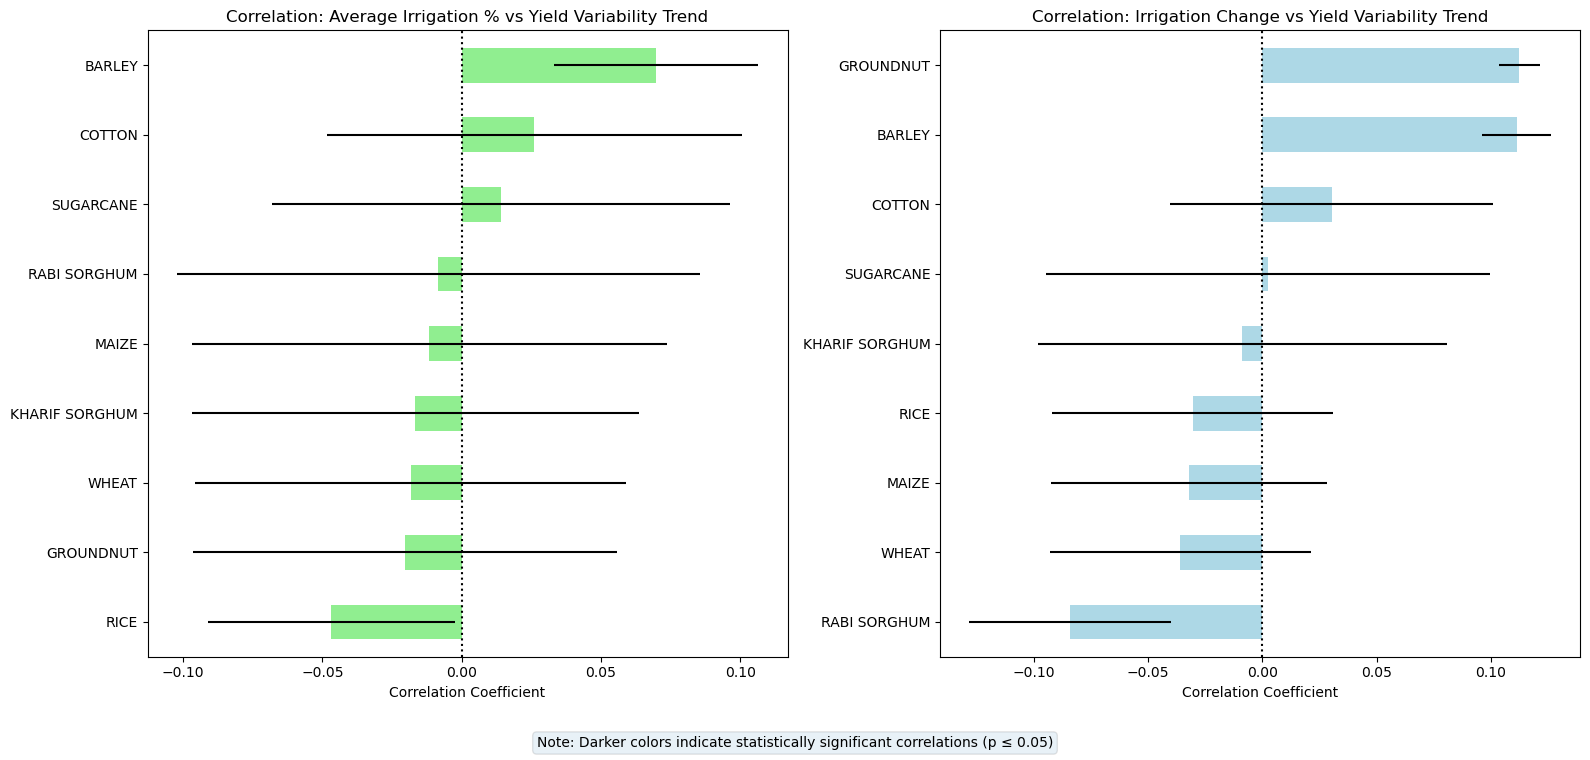

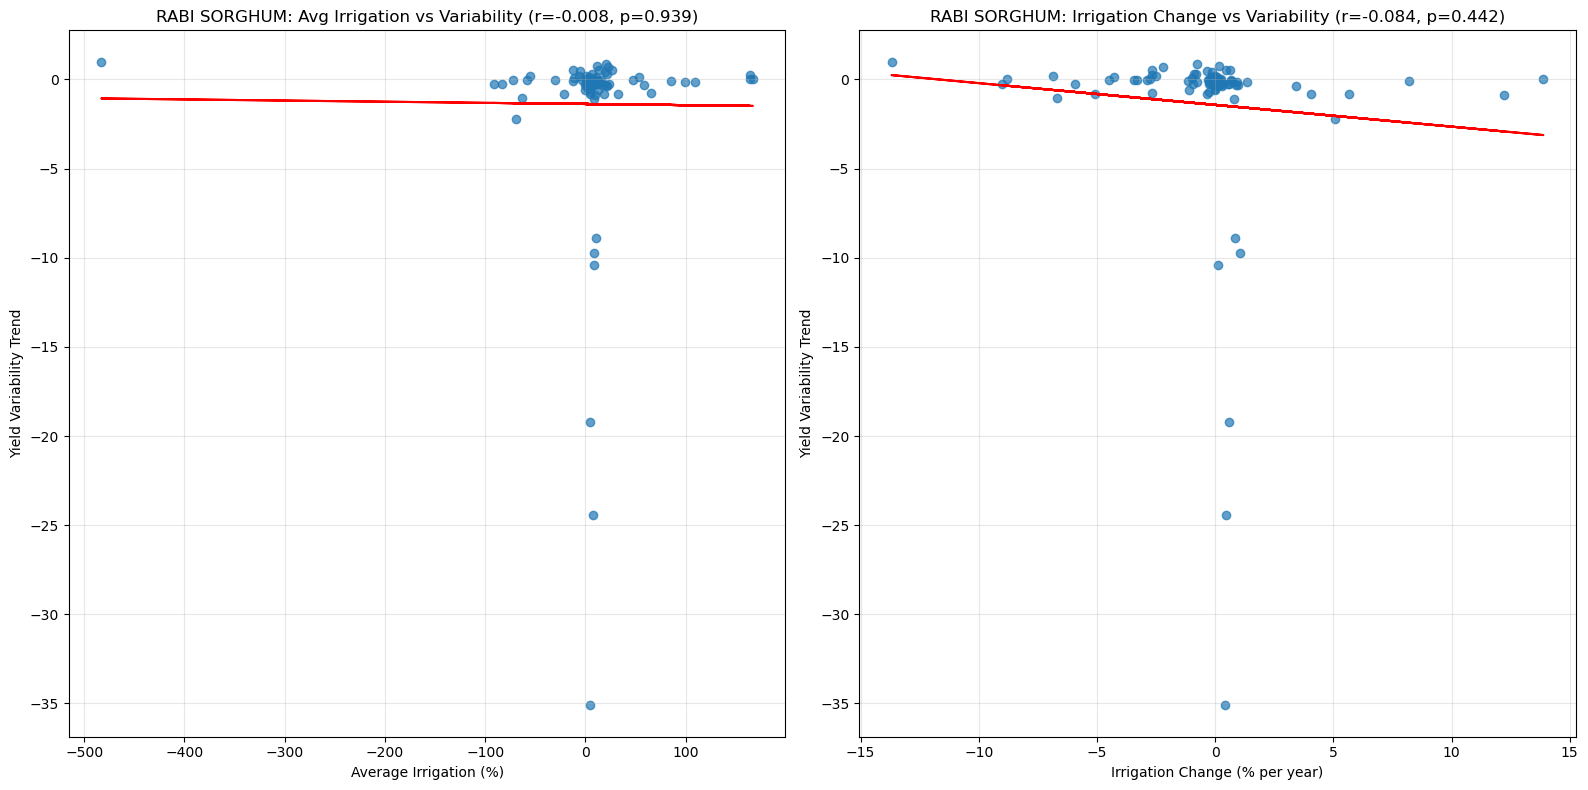

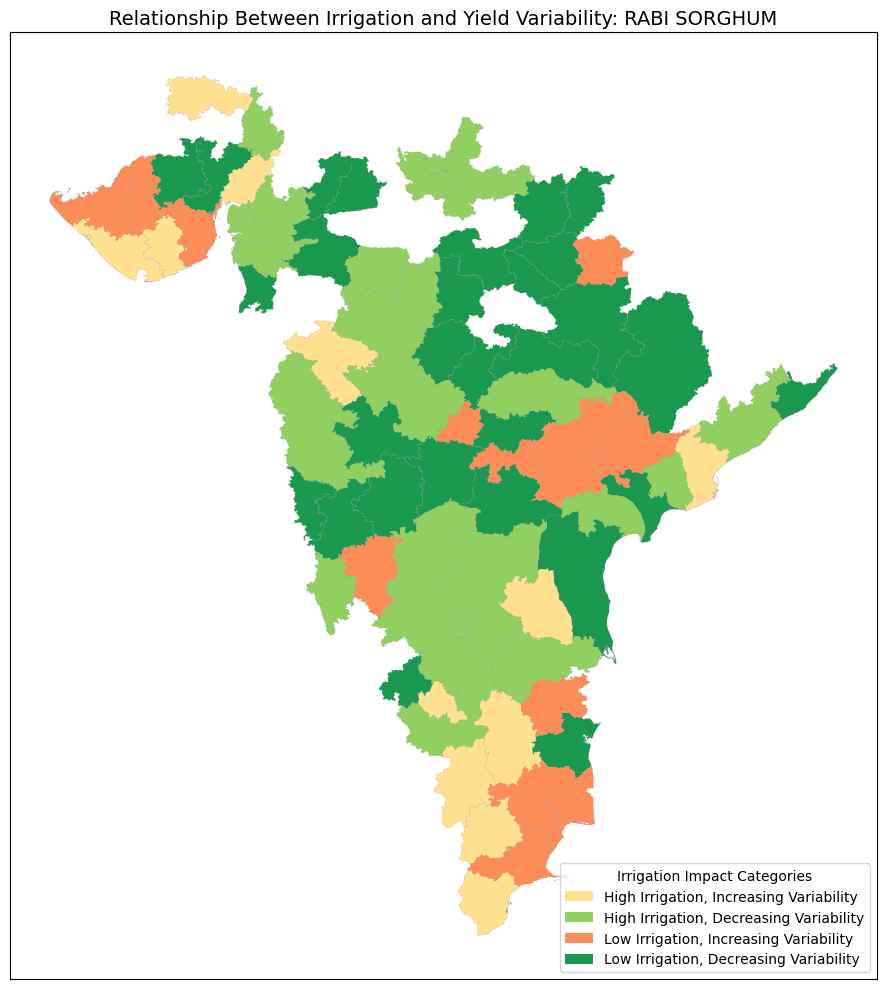

In [39]:
#Example usage:
# Load and preprocess data
# gdf = ... # Your original geodataframe with crop data
# filtered_gdf = preprocess_crop_data(gdf, crops_to_analyze)

# Calculate anomaly magnitude trends
gdf_with_trends = calculate_anomaly_magnitude_trends(filtered_gdf, crops_to_analyze)

# Load and merge irrigation data
irrigation_file_path = "/Users/michaelfoley/Library/CloudStorage/GoogleDrive-mfoley@g.harvard.edu/My Drive/Subnational_Yield_Database/data/processed/IND/icrisat_apportioned/ICRISAT-District Level Irrigation Data.csv"
merged_gdf = load_and_merge_irrigation_data(gdf_with_trends, irrigation_file_path)

# Calculate irrigation metrics
gdf_with_irrigation = calculate_irrigation_metrics(merged_gdf, crops_to_analyze)

# Analyze relationship between irrigation and yield variability
results_df, scatter_data = analyze_irrigation_vs_variability(gdf_with_irrigation, crops_to_analyze)

# Plot correlation results
fig = plot_irrigation_variability_correlation(results_df)
plt.savefig('../plots/ICRISAT/irrigation_variability_correlation.png', dpi=300, bbox_inches='tight')

# Plot scatter plot for a specific crop
fig = plot_irrigation_variability_scatter(scatter_data, 'RABI SORGHUM')
plt.savefig('../plots/ICRISAT/rabi_sorghum_irrigation_variability_scatter.png', dpi=300, bbox_inches='tight')

# Create map of irrigation impact
fig = map_irrigation_impact(gdf_with_irrigation, 'RABI SORGHUM')
plt.savefig('../plots/ICRISAT/rabi_sorghum_irrigation_impact_map.png', dpi=300, bbox_inches='tight')

In [40]:
# After calculating anomaly magnitude trends and merging irrigation data
# Calculate the year-by-year correlation between irrigation and anomalies
gdf_with_yearly_correlations = analyze_yearly_irrigation_anomaly_correlation(merged_gdf, crops_to_analyze)

# Create maps for each crop
for crop in crops_to_analyze:
    print(crop)
    if crop == 'SOYABEAN':
        continue
    fig = map_yearly_irrigation_anomaly_correlation(gdf_with_yearly_correlations, crop)
    if fig:
        plt.savefig(f'../plots/ICRISAT/{crop}_yearly_irrigation_anomaly_correlation.png', dpi=300, bbox_inches='tight')
        plt.close(fig)

/var/folders/16/y9h7_0ld1418y9zts1sf_3xh0000gn/T/ipykernel_47777/4135347461.py:431: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  district_data['irr_pct'].replace([np.inf, -np.inf], np.nan, inplace=True)
/var/folders/16/y9h7_0ld1418y9zts1sf_3xh0000gn/T/ipykernel_47777/4135347461.py:431: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on whi

RICE
WHEAT
MAIZE
KHARIF SORGHUM
RABI SORGHUM
SOYABEAN
GROUNDNUT
COTTON
SUGARCANE
BARLEY
